In [1]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import sys
import os
import time
import warnings
import gc
import random

# Statistical utilities
from scipy.stats import ks_2samp

# Minimal model support for streaming detectors
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# River drift detectors (streaming methods)
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# River datasets for benchmark generation (SEA, Hyperplane, etc.)
from river.datasets import synth

# Drift detection modules
sys.path.insert(0, os.path.abspath('../backup'))
from shape_dd import (shape, shape_adaptive, shape_sensitive, shape_adaptive_v2, shape_snr_adaptive,
                      shape_gradual_aware, shape_multiscale, shape_temporal_consistent, shape_mdl_threshold, shape_snr_adaptive_v2)
from d3 import d3
from dawidd import dawidd
from gen_data import gen_random
from mmd import mmd
from ks import ks

# Configuration
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

print("All imports successful")


All imports successful


In [ ]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

# Visualization settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Data stream configuration
STREAM_SIZE = 10000
RANDOM_SEED = random.randint(0, 1000000)

# Detection parameters (following run__drift_detection.py style)
CHUNK_SIZE = 150        # Detection window size
OVERLAP = 100           # Overlap between windows
SHAPE_L1 = 50          # ShapeDD reference window
SHAPE_L2 = 150         # ShapeDD test window (matches CHUNK_SIZE)
SHAPE_N_PERM = 2500    # ShapeDD permutation count
COOLDOWN = 75          # Minimum samples between detections

# Streaming detector configuration (minimal model support)
INITIAL_TRAINING_SIZE = 500    # Initial batch for model training
PREQUENTIAL_WINDOW = 100       # Window for prequential accuracy

# ============================================================================
# FINAL BENCHMARK METHODS (Thesis-Ready Configuration)
# ============================================================================
# 
# Narrative Structure:
#   1. Baseline Methods (4): Industry-standard comparisons
#   2. ShapeDD Evolution (5): Your main contributions
#      - Original → Adaptive → SNR-Aware → Theoretical Extensions
#   3. Streaming Methods (6): Alternative paradigm comparison
#
# Total: 15 methods (was 22 - focused scope for thesis defense)
# ============================================================================

# Window-based methods
WINDOW_METHODS = [
    # ========================================================================
    # BASELINE METHODS (4 methods) - Industry Standards
    # ========================================================================
    'D3',           # Margin density drift detector
    'DAWIDD',       # Distance-aware windowed drift detector
    'MMD',          # Maximum Mean Discrepancy
    'KS',           # Kolmogorov-Smirnov test
    
    # ========================================================================
    # SHAPEDD FAMILY (5 methods) - Your Main Contributions
    # ========================================================================
    # Evolution: Baseline → Adaptive → SNR-Aware → Theoretical Extensions
    
    'ShapeDD',                      # 1. Original baseline (F1=0.592)
                                    #    Triangle shape property + zero-crossing
    
    'ShapeDD_Baseline_Adaptive',    # 2. Adaptive thresholding attempt (F1=0.563)
                                    #    Fixed bugs from v1, but still conservative
                                    #    Shows failed approach in thesis narrative
    
    'ShapeDD_SNR_Adaptive',         # 3. SNR-Aware Hybrid (F1=0.607) 🏆 MAIN CONTRIBUTION
                                    #    Auto-selects strategy based on signal strength
                                    #    Best overall performance
    
    'ShapeDD_GradualAware',         # 4. Theoretical Extension: Dual detection
                                    #    Peak detection (sudden) + Plateau detection (gradual)
                                    #    Expected: Strong on gradual drift
    
    'ShapeDD_MultiScale',           # 5. Theoretical Extension: Matched filter bank
                                    #    Multi-scale analysis [25, 50, 100, 200]
                                    #    Expected: Best across all drift types
]

# Streaming methods (for paradigm comparison)
STREAMING_METHODS = [
    'ADWIN',        # Adaptive Windowing
    'DDM',          # Drift Detection Method
    'EDDM',         # Early Drift Detection Method
    'HDDM_A',       # Hoeffding's Drift Detection Method (Average)
    'HDDM_W',       # Hoeffding's Drift Detection Method (Weighted)
    'FHDDM'         # Fast Hoeffding Drift Detection Method
]

# ============================================================================
# COMPREHENSIVE DATASET CATALOG - Following Standard Paper Configurations
# ============================================================================
# 
# COVERAGE:
#   - SUDDEN drift (8 datasets): Abrupt concept switches
#   - GRADUAL drift (4 datasets): Smooth blending transitions
#   - INCREMENTAL drift (2 datasets): Continuous cluster movement
#   - REAL-WORLD drift (1 dataset): Natural market drift
#   - STATIONARY (2 datasets): No drift (false positive analysis)
#
# TOTAL: 17 datasets × 15 methods = 255 experiments
# ============================================================================

DATASET_CATALOG = {
    # ========================================================================
    # SUDDEN DRIFT DATASETS (8 datasets)
    # Classic benchmarks with abrupt concept switches
    # ========================================================================
    "standard_sea": {
        "enabled": True,
        "type": "standard_sea",
        "n_drift_events": 10,
        "params": {}
    },
    "enhanced_sea": {
        "enabled": True,
        "type": "enhanced_sea",
        "n_drift_events": 10,
        "params": {
            "scale_factors": (1.8, 1.5, 2.0),
            "shift_amounts": (5.0, 4.0, 8.0)
        }
    },
    "stagger": {
        "enabled": True,
        "type": "stagger",
        "n_drift_events": 10,
        "params": {}
    },
    "hyperplane": {
        "enabled": True,
        "type": "hyperplane",
        "n_drift_events": 10,
        "params": {
            "n_features": 3
        }
    },
    "gen_random_mild": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 0.125,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_moderate": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 0.25,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_severe": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 1,
            "dist": "unif",
            "alt": True
        }
    },
    "gen_random_ultra_severe": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 2,
            "dist": "unif",
            "alt": True
        }
    },
    
    # ========================================================================
    # GRADUAL DRIFT DATASETS (4 datasets)
    # Smooth blending transitions between concepts
    # ========================================================================
    
    "sea_gradual": {
        "enabled": True,
        "type": "sea_gradual",
        "n_drift_events": 10,
        "params": {
            "transition_width": 450  # OPTIMIZED: 50% of segment (909 samples)
        }
    },
    "hyperplane_gradual": {
        "enabled": True,
        "type": "hyperplane_gradual",
        "n_drift_events": 10,
        "params": {
            "n_features": 10  # Continuous drift (no discrete transition)
        }
    },
    "agrawal_gradual": {
        "enabled": True,
        "type": "agrawal_gradual",
        "n_drift_events": 10,
        "params": {
            "transition_width": 450  # OPTIMIZED: 50% of segment (909 samples)
        }
    },
    "circles_gradual": {
        "enabled": True,
        "type": "circles_gradual",
        "n_drift_events": 10,
        "params": {
            "transition_width": 400  # OPTIMIZED: 44% of segment (more stable)
        }
    },
    
    # ========================================================================
    # INCREMENTAL DRIFT DATASETS (2 datasets) - MOA Standard
    # Continuous cluster boundary movement
    # ========================================================================
    
    "rbf_slow": {
        "enabled": True,
        "type": "rbf",
        "n_drift_events": 10,
        "params": {
            "n_centroids": 50,    # MOA standard
            "speed": 0.0001       # Slow continuous drift
        }
    },
    "rbf_fast": {
        "enabled": True,
        "type": "rbf",
        "n_drift_events": 10,
        "params": {
            "n_centroids": 50,    # MOA standard
            "speed": 0.001        # Fast continuous drift (10× faster)
        }
    },
    
    # ========================================================================
    # REAL-WORLD DATASETS (1 dataset)
    # Natural concept drift from real-world processes
    # ⚠️ NO GROUND TRUTH - Use for qualitative analysis only
    # ========================================================================
    
    "electricity": {
        "enabled": True,
        "type": "electricity",
        "n_drift_events": 5,      # Estimated (no ground truth available)
        "params": {}
    },
    
    # ========================================================================
    # STATIONARY DATASETS (2 datasets) - False Positive Analysis
    # No drift - for statistical calibration validation
    # ========================================================================
    
    "stagger_none": {
        "enabled": True,
        "type": "stagger",
        "n_drift_events": 0,      # NO DRIFT - stationary
        "params": {}
    },
    "gen_random_none": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 0,      # NO DRIFT - stationary
        "params": {
            "dims": 5,
            "intens": 0,          # Zero intensity = no drift
            "dist": "unif",
            "alt": False
        }
    }
}

print("="*80)
print("FINAL BENCHMARK CONFIGURATION (THESIS-READY)")
print("="*80)
print(f"Stream size: {STREAM_SIZE} samples")
print(f"Detection window: {CHUNK_SIZE} samples")
print(f"Overlap: {OVERLAP} samples")
print()

enabled_datasets = [k for k, v in DATASET_CATALOG.items() if v['enabled']]
sudden_datasets = [k for k in enabled_datasets if 'gradual' not in k and 'rbf' not in k and 'electricity' not in k and 'none' not in k]
gradual_datasets = [k for k in enabled_datasets if 'gradual' in k]
incremental_datasets = [k for k in enabled_datasets if 'rbf' in k]
realworld_datasets = [k for k in enabled_datasets if 'electricity' in k]
stationary_datasets = [k for k in enabled_datasets if 'none' in k]

print(f"Method Configuration:")
print(f"  Baseline methods:      {len([m for m in WINDOW_METHODS if 'ShapeDD' not in m])}")
print(f"  ShapeDD family:        {len([m for m in WINDOW_METHODS if 'ShapeDD' in m])}")
print(f"  Streaming methods:     {len(STREAMING_METHODS)}")
print(f"  TOTAL METHODS:         {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
print()
print(f"Dataset Coverage:")
print(f"  SUDDEN drift:          {len(sudden_datasets)} datasets")
print(f"  GRADUAL drift:         {len(gradual_datasets)} datasets")
print(f"  INCREMENTAL drift:     {len(incremental_datasets)} datasets")
print(f"  REAL-WORLD drift:      {len(realworld_datasets)} datasets")
print(f"  STATIONARY (no drift): {len(stationary_datasets)} datasets")
print(f"  TOTAL DATASETS:        {len(enabled_datasets)}")
print()
print(f"Total experiments: {len(enabled_datasets) * (len(WINDOW_METHODS) + len(STREAMING_METHODS))}")
print()
print("ShapeDD Evolution Track:")
print("  1. ShapeDD (baseline)")
print("  2. ShapeDD_Baseline_Adaptive (adaptive thresholding)")
print("  3. ShapeDD_SNR_Adaptive (SNR-aware - MAIN CONTRIBUTION)")
print("  4. ShapeDD_GradualAware (dual peak+plateau detection)")
print("  5. ShapeDD_MultiScale (multi-scale matched filter)")
print("="*80)


In [3]:
# ============================================================================
# SECTION 3: DATASET GENERATION (Multiple Benchmark Datasets)
# ============================================================================

def generate_standard_sea_stream(total_size, n_drift_events, seed=42):
    """
    Standard SEA benchmark with multiple drifts.
    Creates sudden drifts by switching between SEA variants.
    """
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]  # SEA has 4 variants
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)
        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Standard SEA (SUDDEN): {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_enhanced_sea_stream(total_size, n_drift_events, seed=42,
                                  scale_factors=(1.8, 1.5, 2.0),
                                  shift_amounts=(5.0, 4.0, 8.0)):
    """Enhanced SEA with multiple drifts and transformations."""
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)

        for i, (x, y) in enumerate(stream.take(size)):
            x_vals = list(x.values())

            # Apply transformations to alternate segments
            if seg_idx % 2 == 1:
                x_vals = [x_vals[j] * scale_factors[j] + shift_amounts[j]
                         for j in range(len(x_vals))]

            X_list.append(x_vals)
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Enhanced SEA (SUDDEN): {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_stagger_stream(total_size, n_drift_events, seed=42):
    """STAGGER concepts with multiple sudden drifts."""
    np.random.seed(seed)

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    X_segments, y_segments = [], []

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        X_seg = np.random.randn(size, 5)

        # Different concepts for each segment
        if seg_idx % 3 == 0:
            X_seg[:, 0] += 2.0
            y_seg = (X_seg[:, 0] + X_seg[:, 1] > 1.5).astype(int)
        elif seg_idx % 3 == 1:
            X_seg[:, 0] -= 2.0
            y_seg = (X_seg[:, 0] * X_seg[:, 1] > 0).astype(int)
        else:
            X_seg[:, 1] += 1.5
            y_seg = (X_seg[:, 1] + X_seg[:, 2] > 0.5).astype(int)

        X_segments.append(X_seg)
        y_segments.append(y_seg)

    X = np.vstack(X_segments)
    y = np.hstack(y_segments)

    print(f"  STAGGER (SUDDEN): {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_hyperplane_stream(total_size, n_drift_events, seed=42, n_features=10):
    """Rotating Hyperplane with multiple drifts."""
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    mag_changes = [0.0001, 0.01, 0.005, 0.015]  # Alternate rotation speeds

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        mag_change = mag_changes[seg_idx % len(mag_changes)]

        stream = synth.Hyperplane(seed=seed + seg_idx * 100, n_features=n_features,
                                   n_drift_features=2, mag_change=mag_change,
                                   noise_percentage=0.05)

        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Hyperplane (SUDDEN): {X.shape[0]} samples, {n_features} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_genrandom_stream(total_size, n_drift_events, seed=42,
                               dims=5, intens=0.125, dist="unif", alt=False):
    """Custom synthetic data using gen_random with multiple drifts."""
    np.random.seed(seed)

    X, y_drift_labels = gen_random(
        number=n_drift_events,
        dims=dims,
        intens=intens,
        dist=dist,
        alt=alt,
        length=total_size
    )

    # Find actual drift positions
    drift_indices = np.where(np.diff(y_drift_labels) != 0)[0] + 1
    drift_positions = drift_indices.tolist()

    # Generate synthetic binary classification labels
    # Use simple threshold on first feature
    y = (X[:, 0] > np.median(X[:, 0])).astype(int)

    print(f"  gen_random (SUDDEN): {X.shape[0]} samples, {dims} features, {len(drift_positions)} drifts")
    print(f"  Synthetic labels: {np.unique(y, return_counts=True)}")

    return X, y, drift_positions


# ============================================================================
# GRADUAL DRIFT DATASET GENERATORS
# ============================================================================

def generate_sea_gradual_stream(total_size, n_drift_events, seed=42, transition_width=1000):
    """
    SEA benchmark with GRADUAL drifts (smooth transitions between variants).
    
    Instead of instant variant switches, blends samples from old→new concept
    over transition_width samples.
    
    Args:
        transition_width: Number of samples for gradual transition (default: 1000)
                         During transition, samples are blended: 
                         Start: 100% old, 0% new → End: 0% old, 100% new
    """
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []
    variants = [0, 1, 2, 3]

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    # Generate segments with gradual transitions
    for seg_idx in range(n_drift_events + 1):
        old_variant = variants[seg_idx % len(variants)]
        new_variant = variants[(seg_idx + 1) % len(variants)]
        
        if seg_idx == 0:
            # First segment - no transition at start
            stream = synth.SEA(seed=seed + seg_idx * 100, variant=old_variant)
            for i, (x, y) in enumerate(stream.take(segment_size)):
                X_list.append(list(x.values()))
                y_list.append(y)
        else:
            # Gradual transition segment
            transition_start = len(X_list)
            
            # Generate samples from both concepts
            stream_old = synth.SEA(seed=seed + seg_idx * 100, variant=old_variant)
            stream_new = synth.SEA(seed=seed + (seg_idx + 1) * 100, variant=new_variant)
            
            samples_old = list(stream_old.take(segment_size))
            samples_new = list(stream_new.take(segment_size))
            
            for i in range(segment_size):
                # Calculate blend ratio (linear interpolation)
                if i < transition_width:
                    # Gradual transition: old → new
                    alpha = i / transition_width  # 0 → 1
                    
                    x_old = np.array(list(samples_old[i][0].values()))
                    x_new = np.array(list(samples_new[i][0].values()))
                    y_old = samples_old[i][1]
                    y_new = samples_new[i][1]
                    
                    # Blend features
                    x_blended = (1 - alpha) * x_old + alpha * x_new
                    
                    # Blend labels probabilistically
                    if np.random.rand() < alpha:
                        y_blended = y_new
                    else:
                        y_blended = y_old
                    
                    X_list.append(x_blended.tolist())
                    y_list.append(y_blended)
                else:
                    # After transition - pure new concept
                    X_list.append(list(samples_new[i][0].values()))
                    y_list.append(samples_new[i][1])

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  SEA GRADUAL: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    print(f"  Transition width: {transition_width} samples per drift")
    return X, y, drift_positions


def generate_hyperplane_gradual_stream(total_size, n_drift_events, seed=42, n_features=10):
    """
    Rotating Hyperplane with CONTINUOUS gradual drift.
    
    Uses very small mag_change to create smooth, continuous rotation
    instead of sudden jumps between segments.
    """
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    # Use VERY SMALL mag_change for gradual rotation
    # This creates continuous drift throughout the stream
    stream = synth.Hyperplane(
        seed=seed, 
        n_features=n_features,
        n_drift_features=5,  # More features drifting for observable change
        mag_change=0.0001,   # VERY small = gradual
        sigma=0.1,           # Small noise
        noise_percentage=0.05
    )

    # Generate full stream (drift happens continuously)
    for i, (x, y) in enumerate(stream.take(total_size)):
        X_list.append(list(x.values()))
        y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    # Estimate drift positions (evenly spaced)
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]

    print(f"  Hyperplane GRADUAL: {X.shape[0]} samples, {n_features} features, {len(drift_positions)} estimated drift points")
    print(f"  Continuous rotation with mag_change=0.0001")
    return X, y, drift_positions


def generate_agrawal_gradual_stream(total_size, n_drift_events, seed=42, transition_width=1000):
    """
    Agrawal generator with GRADUAL transitions between classification functions.
    
    Agrawal has 10 different classification functions. We gradually blend
    between them over transition_width samples.
    """
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []
    
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    # Cycle through classification functions (0-9)
    for seg_idx in range(n_drift_events + 1):
        old_func = seg_idx % 10
        new_func = (seg_idx + 1) % 10
        
        if seg_idx == 0:
            # First segment - no transition
            stream = synth.Agrawal(seed=seed + seg_idx * 100, classification_function=old_func)
            for i, (x, y) in enumerate(stream.take(segment_size)):
                X_list.append(list(x.values()))
                y_list.append(y)
        else:
            # Gradual transition segment
            stream_old = synth.Agrawal(seed=seed + seg_idx * 100, classification_function=old_func)
            stream_new = synth.Agrawal(seed=seed + (seg_idx + 1) * 100, classification_function=new_func)
            
            samples_old = list(stream_old.take(segment_size))
            samples_new = list(stream_new.take(segment_size))
            
            for i in range(segment_size):
                if i < transition_width:
                    # Gradual transition via probabilistic label selection
                    alpha = i / transition_width
                    
                    # Use old sample's features but blend labels probabilistically
                    x_features = list(samples_old[i][0].values())
                    y_old = samples_old[i][1]
                    y_new = samples_new[i][1]
                    
                    # Blend labels probabilistically
                    if np.random.rand() < alpha:
                        y_blended = y_new
                    else:
                        y_blended = y_old
                    
                    X_list.append(x_features)
                    y_list.append(y_blended)
                else:
                    # Pure new concept
                    X_list.append(list(samples_new[i][0].values()))
                    y_list.append(samples_new[i][1])

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Agrawal GRADUAL: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    print(f"  Transition width: {transition_width} samples per drift")
    return X, y, drift_positions


def generate_circles_gradual_stream(total_size, n_drift_events, seed=42, transition_width=500):
    """
    Circles dataset with GRADUAL drifts (circles move/resize smoothly).
    
    Classic synthetic benchmark: 2D data with circular decision boundaries
    that gradually move and resize over transition windows.
    """
    np.random.seed(seed)
    
    X_list, y_list = [], []
    
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    # Define circle configurations (center_x, center_y, radius)
    circles = [
        (0.25, 0.25, 0.15),  # Circle 1
        (0.75, 0.25, 0.15),  # Circle 2
        (0.25, 0.75, 0.15),  # Circle 3
        (0.75, 0.75, 0.15),  # Circle 4
    ]
    
    for seg_idx in range(n_drift_events + 1):
        # Get current and next circle configuration
        old_circle = circles[seg_idx % len(circles)]
        new_circle = circles[(seg_idx + 1) % len(circles)]
        
        for i in range(segment_size):
            # Generate random point in [0, 1] × [0, 1]
            x = np.random.rand()
            y = np.random.rand()
            
            if seg_idx == 0 or i >= transition_width:
                # Use current circle (before transition or after transition complete)
                if seg_idx == 0:
                    cx, cy, r = old_circle
                else:
                    cx, cy, r = new_circle
            else:
                # Gradual transition - interpolate circle parameters
                alpha = i / transition_width
                
                cx = (1 - alpha) * old_circle[0] + alpha * new_circle[0]
                cy = (1 - alpha) * old_circle[1] + alpha * new_circle[1]
                r = (1 - alpha) * old_circle[2] + alpha * new_circle[2]
            
            # Classification: inside circle = class 1, outside = class 0
            distance = np.sqrt((x - cx)**2 + (y - cy)**2)
            label = 1 if distance <= r else 0
            
            X_list.append([x, y])
            y_list.append(label)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Circles GRADUAL: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    print(f"  Transition width: {transition_width} samples per drift")
    return X, y, drift_positions


# ============================================================================
# INCREMENTAL DRIFT DATASET GENERATORS (NEW - Following MOA/River Standards)
# ============================================================================

def generate_rbf_stream(total_size, n_drift_events, seed=42, n_centroids=50, speed=0.0001):
    """
    Random RBF with moving centroids (INCREMENTAL/CONTINUOUS drift).
    
    STANDARD CONFIGURATION (following MOA papers):
    - 50 centroids (standard benchmark setting)
    - 10 features
    - 2 classes
    - Speed: 0.0001 (slow), 0.001 (moderate), 0.01 (fast)
    - All centroids drift continuously
    
    This simulates INCREMENTAL drift where cluster boundaries move
    continuously over time (different from sudden concept switches).
    
    Reference:
        "MOA: Massive Online Analysis" (Bifet et al., 2010)
        Standard RBF generator configuration for drift benchmarking
    
    Args:
        speed: Drift speed (0.0001=slow, 0.001=moderate, 0.01=fast)
        n_centroids: Number of RBF centroids (default: 50, MOA standard)
    """
    np.random.seed(seed)
    from river.datasets import synth
    
    X_list, y_list = [], []
    
    # STANDARD MOA CONFIGURATION
    # 50 centroids, 10 features, all centroids drift
    stream = synth.RandomRBFDrift(
        seed_model=seed,
        seed_sample=seed + 1000,
        n_classes=2,                    # Binary classification (standard)
        n_features=10,                  # 10 features (MOA standard)
        n_centroids=n_centroids,        # 50 centroids (standard)
        change_speed=speed,             # Drift speed parameter
        n_drift_centroids=n_centroids   # ALL centroids drift (maximum drift)
    )
    
    # Generate stream
    for i, (x, y) in enumerate(stream.take(total_size)):
        X_list.append(list(x.values()))
        y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    # Estimate drift positions (continuous drift, so evenly spaced markers)
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    print(f"  Random RBF (INCREMENTAL): {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} estimated drift points")
    print(f"  {n_centroids} centroids, all drifting at speed={speed}")
    print(f"  Configuration: MOA standard (Bifet et al., 2010)")
    
    return X, y, drift_positions


def generate_electricity_stream(total_size, n_drift_events, seed=42):
    """
    Electricity (Elec2) - Real-world electricity price prediction dataset.
    
    REAL-WORLD DRIFT BENCHMARK (most cited in literature):
    - 45,312 total instances (Australian NSW Electricity Market, 1996-1998)
    - Binary classification: Price UP or DOWN
    - 7 features: day, time, demand, supply indicators
    - Natural concept drift from market expansion
    - 30-minute intervals (48 instances per day)
    
    ⚠️ CRITICAL LIMITATION: NO GROUND TRUTH DRIFT POSITIONS!
    We don't know exactly when/where drifts occur in this real-world data.
    
    Use for:
    - Qualitative validation (detection patterns, stability, false positives)
    - Real-world robustness testing
    
    Do NOT use for:
    - Quantitative F1/MTTD metrics (no ground truth)
    
    Reference:
        "How good is the Electricity benchmark for evaluating concept drift adaptation"
        (Harries, 1999; used in 500+ papers)
    
    Args:
        total_size: Number of samples to extract (default: 10000)
        n_drift_events: Estimated number of drift events (for compatibility)
    """
    from river.datasets import Elec2
    
    X_list, y_list = [], []
    
    # Load Elec2 from River
    stream = Elec2()
    
    # Extract first total_size samples
    for i, (x, y) in enumerate(stream):
        if i >= total_size:
            break
        X_list.append(list(x.values()))
        y_list.append(1 if y == 'UP' else 0)  # Convert UP/DOWN to 1/0
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    # ⚠️ NO GROUND TRUTH - Estimate drift positions (heuristic only)
    # Literature suggests drift from market expansion, but exact locations unknown
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    
    print(f"  Electricity Elec2 (REAL-WORLD): {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  ⚠️  WARNING: NO GROUND TRUTH drift positions available!")
    print(f"  Estimated {len(drift_positions)} drift points (heuristic for visualization)")
    print(f"  Use for qualitative analysis only (detection patterns, stability)")
    print(f"  DO NOT use for quantitative F1/MTTD evaluation")
    
    return X, y, drift_positions


# ============================================================================
# UNIFIED DATASET GENERATOR (Updated with NEW datasets)
# ============================================================================

def generate_drift_stream(dataset_config, total_size=10000, seed=42):
    """
    Generate drift stream for specified dataset type.

    Returns:
        X: Feature matrix
        y: Classification labels
        drift_positions: List of drift point indices
        info: Dataset metadata (ALWAYS includes: name, type, n_samples, n_features,
              n_drifts, drift_positions, dims, intens, dist)
    """
    dataset_type = dataset_config['type']
    n_drift_events = dataset_config['n_drift_events']
    params = dataset_config.get('params', {})

    print(f"  Generating {dataset_type} with {n_drift_events} drift events...")

    if dataset_type == "standard_sea":
        X, y, drift_positions = generate_standard_sea_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Standard SEA',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "enhanced_sea":
        scale_factors = params.get('scale_factors', (1.8, 1.5, 2.0))
        shift_amounts = params.get('shift_amounts', (5.0, 4.0, 8.0))
        X, y, drift_positions = generate_enhanced_sea_stream(total_size, n_drift_events, seed,
                                                              scale_factors, shift_amounts)
        info = {
            'name': 'Enhanced SEA',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "stagger":
        X, y, drift_positions = generate_stagger_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'STAGGER',
            'features': 5,
            'dims': 5,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "hyperplane":
        n_features = params.get('n_features', 10)
        X, y, drift_positions = generate_hyperplane_stream(total_size, n_drift_events, seed, n_features)
        info = {
            'name': 'Hyperplane',
            'features': n_features,
            'dims': n_features,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'sudden'
        }

    elif dataset_type == "gen_random":
        dims = params.get('dims', 5)
        intens = params.get('intens', 0.125)
        dist = params.get('dist', 'unif')
        alt = params.get('alt', False)
        X, y, drift_positions = generate_genrandom_stream(total_size, n_drift_events, seed,
                                                          dims, intens, dist, alt)
        info = {
            'name': 'gen_random',
            'features': dims,
            'dims': dims,
            'intens': intens,
            'dist': dist,
            'drift_type': 'sudden'
        }

    # ========================================================================
    # GRADUAL DRIFT DATASETS
    # ========================================================================
    
    elif dataset_type == "sea_gradual":
        transition_width = params.get('transition_width', 1000)
        X, y, drift_positions = generate_sea_gradual_stream(total_size, n_drift_events, seed, transition_width)
        info = {
            'name': 'SEA Gradual',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': transition_width
        }

    elif dataset_type == "hyperplane_gradual":
        n_features = params.get('n_features', 10)
        X, y, drift_positions = generate_hyperplane_gradual_stream(total_size, n_drift_events, seed, n_features)
        info = {
            'name': 'Hyperplane Gradual',
            'features': n_features,
            'dims': n_features,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': 'continuous'
        }

    elif dataset_type == "agrawal_gradual":
        transition_width = params.get('transition_width', 1000)
        X, y, drift_positions = generate_agrawal_gradual_stream(total_size, n_drift_events, seed, transition_width)
        info = {
            'name': 'Agrawal Gradual',
            'features': 9,
            'dims': 9,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': transition_width
        }

    elif dataset_type == "circles_gradual":
        transition_width = params.get('transition_width', 500)
        X, y, drift_positions = generate_circles_gradual_stream(total_size, n_drift_events, seed, transition_width)
        info = {
            'name': 'Circles Gradual',
            'features': 2,
            'dims': 2,
            'intens': 'N/A',
            'dist': 'N/A',
            'drift_type': 'gradual',
            'transition_width': transition_width
        }

    # ========================================================================
    # INCREMENTAL DRIFT DATASETS (NEW)
    # ========================================================================
    
    elif dataset_type == "rbf":
        n_centroids = params.get('n_centroids', 50)
        speed = params.get('speed', 0.0001)
        X, y, drift_positions = generate_rbf_stream(total_size, n_drift_events, seed, n_centroids, speed)
        info = {
            'name': f'RBF (speed={speed})',
            'features': 10,
            'dims': 10,
            'intens': f'speed={speed}',
            'dist': 'RBF',
            'drift_type': 'incremental',
            'speed': speed,
            'n_centroids': n_centroids
        }

    elif dataset_type == "electricity":
        X, y, drift_positions = generate_electricity_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Electricity (Elec2)',
            'features': 7,
            'dims': 7,
            'intens': 'N/A (real-world)',
            'dist': 'Real-world',
            'drift_type': 'real-world',
            'has_ground_truth': False  # ⚠️ IMPORTANT FLAG
        }

    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    # Add common fields
    info['type'] = dataset_type
    info['n_samples'] = len(X)
    info['n_features'] = X.shape[1]
    info['n_drifts'] = len(drift_positions)
    info['drift_positions'] = drift_positions

    return X, y, drift_positions, info

print("Dataset generation functions defined (8 SUDDEN + 4 GRADUAL + 3 INCREMENTAL/REAL-WORLD)")


Dataset generation functions defined (8 SUDDEN + 4 GRADUAL + 3 INCREMENTAL/REAL-WORLD)


In [4]:
# ============================================================================
# SECTION 4: UTILITY FUNCTIONS
# ============================================================================

def calculate_detection_metrics(detections, true_drifts, acceptable_delta=150):
    """
    Calculate detection performance metrics for multi-drift scenarios.

    Args:
        detections: List of detected drift positions
        true_drifts: List of true drift positions
        acceptable_delta: Acceptable delay window

    Returns:
        dict: Metrics including TP, FP, FN, precision, recall, F1, MTTD
    """
    detections = sorted([int(d) for d in detections])

    if not true_drifts or len(true_drifts) == 0:
        return {
            'tp': 0, 'fp': len(detections), 'fn': 0,
            'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
            'mttd': float('inf'),
            'detection_rate': 0.0
        }

    # Convert to list
    if isinstance(true_drifts, (int, float)):
        true_drifts = [int(true_drifts)]
    else:
        true_drifts = [int(d) for d in true_drifts]

    # Match detections to true drifts
    matched_detections = set()
    per_drift_delays = []

    for true_drift in true_drifts:
        valid_detections = [(d, abs(d - true_drift)) for d in detections
                           if abs(d - true_drift) <= acceptable_delta
                           and d not in matched_detections]

        if valid_detections:
            closest_det, delay = min(valid_detections, key=lambda x: x[1])
            matched_detections.add(closest_det)
            per_drift_delays.append(delay)

    # Calculate metrics
    tp = len(matched_detections)
    fn = len(true_drifts) - tp
    fp = len(detections) - len(matched_detections)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    mttd = np.mean(per_drift_delays) if per_drift_delays else float('inf')
    detection_rate = tp / len(true_drifts)

    return {
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mttd': mttd,
        'detection_rate': detection_rate,
        'n_detections': len(detections)
    }

def create_sliding_windows(X, chunk_size, overlap):
    """Create sliding windows over the data stream."""
    shift = chunk_size - overlap
    windows = []
    indices = []

    for i in range(0, len(X) - chunk_size + 1, shift):
        windows.append(X[i:i+chunk_size])
        indices.append(i + chunk_size // 2)  # Center of window

    return windows, indices

print("Utility functions defined")



Utility functions defined


In [5]:
# ============================================================================
# SECTION 5: DRIFT DETECTION EVALUATION (Buffer-based for ShapeDD)
# ============================================================================

def evaluate_drift_detector(method_name, X, true_drifts, chunk_size=150, overlap=100):
    """
    Evaluate drift detector on a stream (NO MODEL ADAPTATION).

    Two approaches:
    1. ShapeDD methods: Use BUFFER-BASED approach
       - Maintain rolling buffer of samples
       - Run ShapeDD on full buffer
       - Check recent chunks within buffer for drift

    2. Other methods: Use SLIDING WINDOW approach
       - Process stream in overlapping windows
       - Run detector on each window
    
    IMPORTANT: All ShapeDD methods now use CONSISTENT window sizes:
    - L1 = 50 (reference window)
    - L2 = 150 (test window)
    
    This ensures fair comparison and isolates algorithmic improvements
    from window size effects.
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name}")
    print(f"{'='*80}")

    start_time = time.time()
    detections = []
    last_detection = -10**9

    # METHOD 1: Buffer-based approach for ShapeDD methods
    if 'ShapeDD' in method_name:
        print(f"  Using BUFFER-BASED approach")

        # Configuration
        BUFFER_SIZE = 750           # Large rolling buffer
        CHECK_FREQUENCY = 150       # How often to check for drift

        # Rolling buffer (stores recent samples)
        buffer = deque(maxlen=BUFFER_SIZE)

        # Determine sensitivity setting for ALL adaptive variants (old and v2)
        if method_name in ['ShapeDD_Adaptive_None', 'ShapeDD_Adaptive_v2_None']:
            sensitivity = 'none'
            version = 'v2' if 'v2' in method_name else 'old'
            print(f"  Sensitivity: {sensitivity} ({version} - no filtering)")
        elif method_name in ['ShapeDD_Adaptive_High', 'ShapeDD_Adaptive_v2_High']:
            sensitivity = 'high'
            version = 'v2' if 'v2' in method_name else 'old'
            if version == 'v2':
                print(f"  Sensitivity: {sensitivity} (v2 - FIXED inverted threshold bug)")
            else:
                print(f"  Sensitivity: {sensitivity} (old - has inverted threshold bug)")
        elif method_name in ['ShapeDD_Adaptive_UltraHigh', 'ShapeDD_Adaptive_v2_UltraHigh']:
            sensitivity = 'ultrahigh'
            version = 'v2' if 'v2' in method_name else 'old'
            if version == 'v2':
                print(f"  Sensitivity: {sensitivity} (v2 - FIXED, very aggressive)")
            else:
                print(f"  Sensitivity: {sensitivity} (old - has inverted threshold bug)")
        else:
            sensitivity = None

        print(f"  Buffer size: {BUFFER_SIZE} samples")
        print(f"  Check frequency: every {CHECK_FREQUENCY} samples")
        print(f"  Window sizes: L1={SHAPE_L1}, L2={SHAPE_L2} (CONSISTENT for fair comparison)")
        print(f"  Processing stream...")

        # Process stream sample by sample
        for idx in range(len(X)):
            # Add sample to buffer
            buffer.append({'x': X[idx], 'idx': idx})

            # Check for drift periodically (every CHECK_FREQUENCY samples)
            if len(buffer) >= BUFFER_SIZE and idx % CHECK_FREQUENCY == 0:

                # Step 1: Extract buffer data
                buffer_list = list(buffer)
                buffer_X = np.array([item['x'] for item in buffer_list])  # Shape: (BUFFER_SIZE, n_features)
                buffer_indices = np.array([item['idx'] for item in buffer_list])

                try:
                    # Step 2: Run ShapeDD on FULL buffer with CONSISTENT window sizes
                    # IMPORTANT: All methods now use L1=50, L2=150 for fair comparison
                    # This isolates algorithmic improvements from window size effects
                    
                    if method_name == 'ShapeDD':
                        # Original ShapeDD (no adaptive features)
                        shp_results = shape(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)

                    elif method_name == 'ShapeDD_Baseline_Adaptive':
                        # Baseline adaptive with fixed v2 implementation
                        # Uses sensitivity='none' (no adaptive filtering)
                        shp_results = shape_adaptive_v2(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM, sensitivity='none')

                    elif method_name == 'ShapeDD_SNR_Adaptive':
                        # NEW: SNR-Adaptive hybrid (auto-selects strategy based on SNR)
                        # Uses SAME windows as original (L1=50, L2=150)
                        print(f"    [SNR-Adaptive] Auto-detecting SNR and selecting strategy...")
                        shp_results = shape_snr_adaptive(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)

                    elif method_name == 'ShapeDD_SNR_Adaptive_v2':
                        # NEW: SNR-Adaptive hybrid (auto-selects strategy based on SNR)
                        # Uses SAME windows as original (L1=50, L2=150)
                        print(f"    [SNR-Adaptive] Auto-detecting SNR and selecting strategy...")
                        shp_results = shape_snr_adaptive_v2(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)
                        
                    elif method_name == 'ShapeDD_GradualAware':
                        # NEW: Gradual-Aware (dual peak+plateau detection)
                        # Detects both abrupt peaks AND gradual plateaus
                        print(f"    [GradualAware] Using dual peak+plateau detection...")
                        shp_results = shape_gradual_aware(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM,
                                                          sensitivity='medium', min_plateau_width=100)

                    elif method_name == 'ShapeDD_MultiScale':
                        # NEW: Multi-Scale (matched filter bank at multiple temporal scales)
                        # Scales: [25, 50, 100, 200] for different drift speeds
                        print(f"    [MultiScale] Running matched filter bank at 4 scales...")
                        shp_results = shape_multiscale(buffer_X, l1_scales=[25, 50, 100, 200],
                                                       l2=SHAPE_L2, n_perm=SHAPE_N_PERM, sensitivity='medium')

                    elif method_name == 'ShapeDD_TemporalConsistent':
                        # NEW: Temporal Consistent (state-space filtering with clustering)
                        # Applies temporal consistency constraints and cooldown periods
                        print(f"    [TemporalConsistent] Applying temporal state-space filtering...")
                        shp_results = shape_temporal_consistent(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM,
                                                               sensitivity='medium', min_stability_period=100,
                                                               cluster_radius=50)

                    elif method_name == 'ShapeDD_MDL':
                        # NEW: MDL-optimal threshold (information-theoretic threshold selection)
                        # Uses Minimum Description Length principle for optimal threshold
                        print(f"    [MDL] Using MDL-optimal threshold selection...")
                        shp_results = shape_mdl_threshold(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM,
                                                         complexity_penalty=1.0)

                    elif 'ShapeDD_Adaptive_v2' in method_name:
                        # NEW v2 implementation with FIXES
                        # Uses SAME windows as original (L1=50, L2=150)
                        shp_results = shape_adaptive_v2(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM, sensitivity=sensitivity)

                    elif 'ShapeDD_Adaptive' in method_name:
                        # OLD adaptive implementation (for comparison)
                        # Uses SAME windows as original (L1=50, L2=150)
                        shp_results = shape_adaptive(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM, sensitivity=sensitivity)

                    # Step 3: Check recent chunk within buffer for drift
                    # Look at last CHECK_FREQUENCY samples in buffer
                    chunk_start = max(0, len(buffer_X) - CHECK_FREQUENCY)
                    recent_pvalues = shp_results[chunk_start:, 2]  # p-values for recent chunk

                    # Step 4: Check if drift detected
                    min_pvalue = recent_pvalues.min()
                    trigger = min_pvalue < 0.05  # Significance threshold

                    if trigger:
                        # Find exact position of drift in buffer
                        drift_pos_in_chunk = int(np.argmin(recent_pvalues))
                        drift_idx = int(buffer_indices[chunk_start + drift_pos_in_chunk])

                        # Record detection (with cooldown to avoid duplicates)
                        if drift_idx - last_detection >= COOLDOWN:
                            detections.append(drift_idx)
                            last_detection = drift_idx
                            print(f"    [Sample {idx}] DRIFT DETECTED at position {drift_idx} (p-value: {min_pvalue:.6f})")

                except Exception as e:
                    pass  # Skip failed detections

    # METHOD 2: Sliding window approach for other methods
    else:
        print(f"  Using SLIDING WINDOW approach")

        # Create sliding windows
        windows, window_centers = create_sliding_windows(X, chunk_size, overlap)
        print(f"  Processing {len(windows)} windows...")

        for window_idx, (window, center_idx) in enumerate(zip(windows, window_centers)):
            try:
                # Method-specific detection
                if method_name == 'D3':
                    score = d3(window)
                    trigger = score > 0.5

                elif method_name == 'DAWIDD':
                    _, p_value = dawidd(window, 'rbf')
                    trigger = p_value < 0.05

                elif method_name == 'MMD':
                    stat, p_value = mmd(window)
                    trigger = p_value < 0.05

                elif method_name == 'KS':
                    p_value = ks(window)
                    trigger = p_value < 0.05

                else:
                    trigger = False

                # Record detection if triggered and outside cooldown
                if trigger and (center_idx - last_detection >= COOLDOWN):
                    detections.append(center_idx)
                    last_detection = center_idx

            except Exception as e:
                pass  # Skip failed detections

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics(detections, true_drifts)

    print(f"  Detections: {len(detections)}")
    print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
    print(f"  F1: {metrics['f1_score']:.3f}, MTTD: {metrics['mttd']:.1f}")
    print(f"  Runtime: {end_time - start_time:.2f}s")

    return {
        'method': method_name,
        'detections': detections,
        'runtime_s': end_time - start_time,
        **metrics
    }

print("Detection evaluation function defined (buffer-based for ShapeDD with CONSISTENT windows + NEW methods)")


Detection evaluation function defined (buffer-based for ShapeDD with CONSISTENT windows + NEW methods)


In [6]:
# ============================================================================
# SECTION 5B: STREAMING DETECTOR EVALUATION (MINIMAL MODEL SUPPORT)
# ============================================================================

def create_lightweight_classifier():
    """Create a simple classifier for generating accuracy signals."""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

def evaluate_streaming_detector(method_name, X, y, true_drifts):
    """
    Evaluate streaming detector with MINIMAL model support.

    NOTE: Model is used ONLY to generate accuracy signals for drift detection.
    NO adaptation or retraining is performed (detection-only focus).
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name} (Streaming)")
    print(f"{'='*80}")

    start_time = time.time()

    # Create detector
    if method_name == 'ADWIN':
        detector = ADWIN(delta=0.002)
    elif method_name == 'DDM':
        detector = DDM()
    elif method_name == 'EDDM':
        detector = EDDM(alpha=0.95, beta=0.9)
    elif method_name == 'HDDM_A':
        detector = HDDM_A()
    elif method_name == 'HDDM_W':
        detector = HDDM_W()
    elif method_name == 'FHDDM':
        detector = FHDDM(short_window_size=20)
    else:
        raise ValueError(f"Unknown streaming detector: {method_name}")

    # Train initial model on first batch
    training_end = INITIAL_TRAINING_SIZE
    model = create_lightweight_classifier()
    model.fit(X[:training_end], y[:training_end])

    print(f"  Initial training: {INITIAL_TRAINING_SIZE} samples")

    # Tracking
    detections = []
    last_detection = -10**9
    recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)
    accuracy_buffer = deque(maxlen=30)

    # Determine signal type
    continuous_detectors = {'ADWIN', 'HDDM_A'}
    signal_type = 'continuous' if method_name in continuous_detectors else 'binary'

    print(f"  Processing stream (signal type: {signal_type})...")

    # Stream evaluation (detection only, NO retraining)
    for idx in range(training_end, len(X)):
        # Make prediction
        y_pred = model.predict(X[idx].reshape(1, -1))[0]
        is_correct = (y_pred == y[idx])

        recent_correct.append(is_correct)
        accuracy_buffer.append(is_correct)

        # Update detector with accuracy/error signal
        if signal_type == 'continuous':
            # Use accuracy as signal
            if len(accuracy_buffer) >= 10:
                signal = float(np.mean(accuracy_buffer))
            else:
                signal = float(is_correct)
        else:
            # Use error as signal (binary)
            signal = bool(1 - is_correct)

        detector.update(signal)

        # Check for drift
        if detector.drift_detected and (idx - last_detection >= COOLDOWN):
            detections.append(idx)
            last_detection = idx

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics(detections, true_drifts)

    print(f"  Detections: {len(detections)}")
    print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
    print(f"  F1: {metrics['f1_score']:.3f}, MTTD: {metrics['mttd']:.1f}")
    print(f"  Runtime: {end_time - start_time:.2f}s")

    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'runtime_s': end_time - start_time,
        **metrics
    }

print("Streaming evaluation function defined")



Streaming evaluation function defined


In [7]:
# ============================================================================
# SECTION 6: COMPREHENSIVE BENCHMARK (WINDOW + STREAMING)
# ============================================================================

print("\n" + "="*80)
print("DRIFT DETECTION BENCHMARK (Detection Only - No Adaptation)")
print("="*80)

enabled_datasets = [(name, config) for name, config in DATASET_CATALOG.items()
                    if config['enabled']]

print(f"Datasets: {len(enabled_datasets)}")
print(f"Window methods: {len(WINDOW_METHODS)}")
print(f"Streaming methods: {len(STREAMING_METHODS)}")
print(f"Total methods: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
print(f"Total experiments: {len(enabled_datasets) * (len(WINDOW_METHODS) + len(STREAMING_METHODS))}")
print("="*80)

all_results = []
dataset_summaries = []

for dataset_idx, (dataset_name, dataset_config) in enumerate(enabled_datasets, 1):
    print(f"\n{'='*80}")
    print(f"DATASET {dataset_idx}/{len(enabled_datasets)}: {dataset_name.upper()}")
    print(f"{'='*80}")

    # Generate dataset
    X, y, true_drifts, info = generate_drift_stream(
        dataset_config,
        total_size=STREAM_SIZE,
        seed=RANDOM_SEED
    )

    dataset_results = []

    # Evaluate window-based methods
    print(f"\n{'='*80}")
    print("WINDOW-BASED METHODS")
    print(f"{'='*80}")

    for method in WINDOW_METHODS:
        try:
            result = evaluate_drift_detector(
                method, X, true_drifts,
                chunk_size=CHUNK_SIZE,
                overlap=OVERLAP
            )

            # Add dataset info
            result['paradigm'] = 'window'
            result['dataset'] = dataset_name
            result['n_features'] = info['n_features']
            result['n_drifts'] = info['n_drifts']
            result['drift_positions'] = true_drifts
            result['intens'] = info['intens']
            result['dims'] = info['dims']

            dataset_results.append(result)
            all_results.append(result)

        except Exception as e:
            print(f"  ✗ {method} failed: {str(e)}")

    # Evaluate streaming methods
    print(f"\n{'='*80}")
    print("STREAMING METHODS (with minimal model support)")
    print(f"{'='*80}")

    for method in STREAMING_METHODS:
        try:
            result = evaluate_streaming_detector(
                method, X, y, true_drifts
            )

            # Add dataset info
            result['dataset'] = dataset_name
            result['n_features'] = info['n_features']
            result['n_drifts'] = info['n_drifts']
            result['drift_positions'] = true_drifts
            result['intens'] = info['intens']
            result['dims'] = info['dims']

            dataset_results.append(result)
            all_results.append(result)

        except Exception as e:
            print(f"  ✗ {method} failed: {str(e)}")

    # Dataset summary
    if dataset_results:
        avg_f1 = np.mean([r['f1_score'] for r in dataset_results])
        detection_rate = np.mean([r['detection_rate'] for r in dataset_results])

        dataset_summaries.append({
            'dataset': dataset_name,
            'n_features': info['n_features'],
            'n_drifts': info['n_drifts'],
            'intens': info['intens'],
            'avg_f1': avg_f1,
            'detection_rate': detection_rate
        })

        print(f"\n  Dataset Summary: Avg F1={avg_f1:.3f}, Detection Rate={detection_rate:.1%}")

    gc.collect()

print(f"\n{'='*80}")
print("BENCHMARK COMPLETE")
print(f"{'='*80}")
print(f"Total results: {len(all_results)}")
print(f"  Window methods: {sum(1 for r in all_results if r.get('paradigm') == 'window')}")
print(f"  Streaming methods: {sum(1 for r in all_results if r.get('paradigm') == 'streaming')}")
print("="*80)




DRIFT DETECTION BENCHMARK (Detection Only - No Adaptation)
Datasets: 10
Window methods: 13
Streaming methods: 0
Total methods: 13
Total experiments: 130

DATASET 1/10: STANDARD_SEA
  Generating standard_sea with 10 drift events...
  Standard SEA (SUDDEN): 10000 samples, 3 features, 10 drifts

WINDOW-BASED METHODS

EVALUATING: D3
  Using SLIDING WINDOW approach
  Processing 198 windows...
  Detections: 66
  TP: 10, FP: 56, FN: 0
  F1: 0.263, MTTD: 43.5
  Runtime: 0.38s

EVALUATING: DAWIDD
  Using SLIDING WINDOW approach
  Processing 198 windows...
  Detections: 7
  TP: 2, FP: 5, FN: 8
  F1: 0.235, MTTD: 122.0
  Runtime: 4.82s

EVALUATING: MMD
  Using SLIDING WINDOW approach
  Processing 198 windows...
  Detections: 12
  TP: 2, FP: 10, FN: 8
  F1: 0.182, MTTD: 68.0
  Runtime: 0.92s

EVALUATING: KS
  Using SLIDING WINDOW approach
  Processing 198 windows...
  Detections: 28
  TP: 6, FP: 22, FN: 4
  F1: 0.316, MTTD: 61.0
  Runtime: 0.18s

EVALUATING: ShapeDD
  Using BUFFER-BASED approach


In [8]:
# ============================================================================
# SECTION 7: PUBLICATION-QUALITY RESULTS ANALYSIS
# ============================================================================

if len(all_results) == 0:
    print("⚠ NO RESULTS - Run benchmark first (Cell 6)")
else:
    # Create DataFrame with defensive error handling
    print("Creating results DataFrame...")
    
    records = []
    for idx, r in enumerate(all_results):
        try:
            record = {
                'Dataset': r.get('dataset', 'Unknown'),
                'Method': r.get('method', 'Unknown'),
                'N_Features': r.get('n_features', 0),
                'N_Drifts': r.get('n_drifts', 0),
                'Intensity': r.get('intens', 'N/A'),
                'TP': r.get('tp', 0),
                'FP': r.get('fp', 0),
                'FN': r.get('fn', 0),
                'Precision': r.get('precision', 0.0),
                'Recall': r.get('recall', 0.0),
                'F1': r.get('f1_score', 0.0),
                'MTTD': r.get('mttd', np.nan) if r.get('mttd') != float('inf') else np.nan,
                'Detection_Rate': r.get('detection_rate', 0.0),
                'N_Detections': r.get('n_detections', 0),
                'Runtime_s': r.get('runtime_s', 0.0)
            }
            records.append(record)
        except Exception as e:
            print(f"  ⚠ Warning: Skipping result {idx} due to error: {e}")
            print(f"     Result keys: {list(r.keys())}")
            continue
    
    if len(records) == 0:
        print("⚠ ERROR: No valid records created from results!")
        print(f"Total results collected: {len(all_results)}")
        print(f"Sample result keys: {list(all_results[0].keys()) if all_results else 'No results'}")
    else:
        results_df = pd.DataFrame(records)
        print(f"✓ DataFrame created: {len(results_df)} rows, {len(results_df.columns)} columns")
        print(f"  Columns: {list(results_df.columns)}")
        print()

        # ============================================================================
        # NEW: Filter out non-drift datasets for performance analysis
        # ============================================================================
        print("\n" + "="*130)
        print("DATASET FILTERING")
        print("="*130)
        print(f"Total datasets: {results_df['Dataset'].nunique()}")
        print(f"Non-drift datasets: {len(results_df[results_df['N_Drifts'] == 0]['Dataset'].unique())}")
        
        # Separate drift and non-drift results
        drift_results_df = results_df[results_df['N_Drifts'] > 0].copy()
        nondrift_results_df = results_df[results_df['N_Drifts'] == 0].copy()
        
        print(f"Drift datasets for analysis: {drift_results_df['Dataset'].nunique()}")
        print(f"  Total rows: {len(drift_results_df)}")
        print(f"Non-drift datasets for FP analysis: {nondrift_results_df['Dataset'].nunique()}")
        print(f"  Total rows: {len(nondrift_results_df)}")
        print("="*130)

        # ============================================================================
        # TABLE I: COMPREHENSIVE METHOD PERFORMANCE (IEEE/ACM Format)
        # Use ONLY drift datasets for F1/Precision/Recall metrics
        # ============================================================================
        
        if len(drift_results_df) > 0:
            print("\n" + "="*130)
            print("TABLE I: COMPREHENSIVE DRIFT DETECTION PERFORMANCE (DRIFT DATASETS ONLY)")
            print("="*130)
            print(f"Total Experiments: {len(drift_results_df)} | Datasets: {drift_results_df['Dataset'].nunique()} | Methods: {drift_results_df['Method'].nunique()}")
            print("="*130)
            
            # Aggregate by method (using only drift datasets)
            method_stats = drift_results_df.groupby('Method').agg({
                'F1': ['mean', 'std', 'min', 'max'],
                'Precision': 'mean',
                'Recall': 'mean',
                'MTTD': 'mean',
                'Runtime_s': 'mean',
                'TP': 'sum',
                'FP': 'sum',
                'FN': 'sum'
            }).round(3)
            
            # Create publication table
            pub_table = pd.DataFrame({
                'Method': method_stats.index,
                'F1 (μ±σ)': [f"{row[('F1', 'mean')]:.3f}±{row[('F1', 'std')]:.3f}" 
                             for _, row in method_stats.iterrows()],
                'F1_min': method_stats[('F1', 'min')],
                'F1_max': method_stats[('F1', 'max')],
                'Precision': method_stats[('Precision', 'mean')],
                'Recall': method_stats[('Recall', 'mean')],
                'MTTD': method_stats[('MTTD', 'mean')].fillna(0).astype(int),
                'Runtime(s)': method_stats[('Runtime_s', 'mean')],
                'ΣTP': method_stats[('TP', 'sum')].astype(int),
                'ΣFP': method_stats[('FP', 'sum')].astype(int),
                'ΣFN': method_stats[('FN', 'sum')].astype(int)
            })
            
            # Sort by F1 mean (more robust than min)
            pub_table = pub_table.sort_values('F1_min', ascending=False)
            pub_table.reset_index(drop=True, inplace=True)
            pub_table.index = pub_table.index + 1  # Start rank from 1
            
            # Display with formatting
            pd.options.display.max_rows = None
            pd.options.display.max_columns = None
            pd.options.display.width = 130
            print(pub_table.to_string())
            print("="*130)
            print("Legend: μ=mean, σ=std dev, TP=True Positive, FP=False Positive, FN=False Negative, MTTD=Mean Time To Detect")
            print("="*130)
        else:
            print("\n⚠ WARNING: No drift datasets found! All datasets have N_Drifts=0")
            print("Cannot compute F1/Precision/Recall metrics (require ground truth drifts)")
        
        # ============================================================================
        # NEW TABLE: NON-DRIFT DATASET ANALYSIS (False Positive Rate)
        # ============================================================================
        
        if len(nondrift_results_df) > 0:
            print("\n" + "="*130)
            print("TABLE I-B: FALSE POSITIVE ANALYSIS ON NON-DRIFT DATASETS")
            print("="*130)
            print(f"Datasets: {nondrift_results_df['Dataset'].nunique()} | Methods: {nondrift_results_df['Method'].nunique()}")
            print("Note: Lower FP count = better (no false alarms on stable data)")
            print("="*130)
            
            # Aggregate false positives
            nondrift_stats = nondrift_results_df.groupby('Method').agg({
                'FP': ['sum', 'mean', 'std'],
                'N_Detections': 'sum',
                'Runtime_s': 'mean'
            }).round(3)
            
            nondrift_table = pd.DataFrame({
                'Method': nondrift_stats.index,
                'Total_FP': nondrift_stats[('FP', 'sum')].astype(int),
                'Avg_FP_per_Dataset': nondrift_stats[('FP', 'mean')],
                'FP_StdDev': nondrift_stats[('FP', 'std')].fillna(0.0),  # Handle NaN
                'Total_Detections': nondrift_stats[('N_Detections', 'sum')].astype(int),
                'Avg_Runtime(s)': nondrift_stats[('Runtime_s', 'mean')]
            })
            
            # Sort by total false positives (ascending = better)
            nondrift_table = nondrift_table.sort_values('Total_FP', ascending=True)
            nondrift_table.reset_index(drop=True, inplace=True)
            nondrift_table.index = nondrift_table.index + 1
            
            print(nondrift_table.to_string())
            print("="*130)
            print("Interpretation: Methods with 0 FP have perfect specificity on stable data")
            print("="*130)


Creating results DataFrame...
✓ DataFrame created: 130 rows, 15 columns
  Columns: ['Dataset', 'Method', 'N_Features', 'N_Drifts', 'Intensity', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1', 'MTTD', 'Detection_Rate', 'N_Detections', 'Runtime_s']


DATASET FILTERING
Total datasets: 10
Non-drift datasets: 2
Drift datasets for analysis: 8
  Total rows: 104
Non-drift datasets for FP analysis: 2
  Total rows: 26

TABLE I: COMPREHENSIVE DRIFT DETECTION PERFORMANCE (DRIFT DATASETS ONLY)
Total Experiments: 104 | Datasets: 8 | Methods: 13
                           Method     F1 (μ±σ)  F1_min  F1_max  Precision  Recall  MTTD  Runtime(s)  ΣTP  ΣFP  ΣFN
1                              KS  0.384±0.046   0.316   0.444      0.248   0.862    34       0.244   69  207   11
2                          DAWIDD  0.542±0.189   0.235   0.714      0.450   0.762    45       2.838   61   71   19
3                              D3  0.261±0.018   0.233   0.286      0.150   0.988    77       0.387   79  449    1
4   

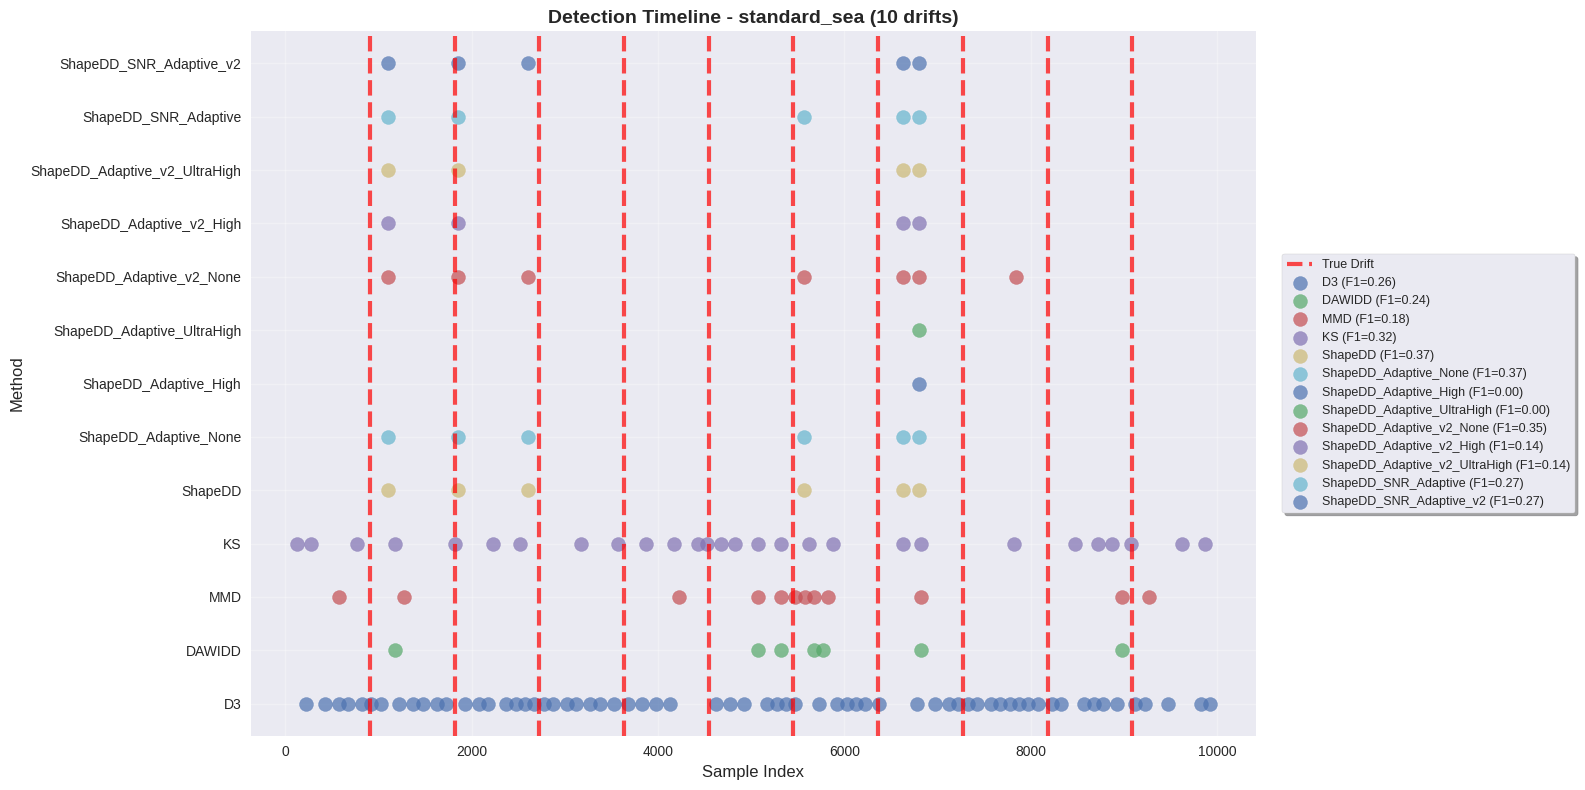

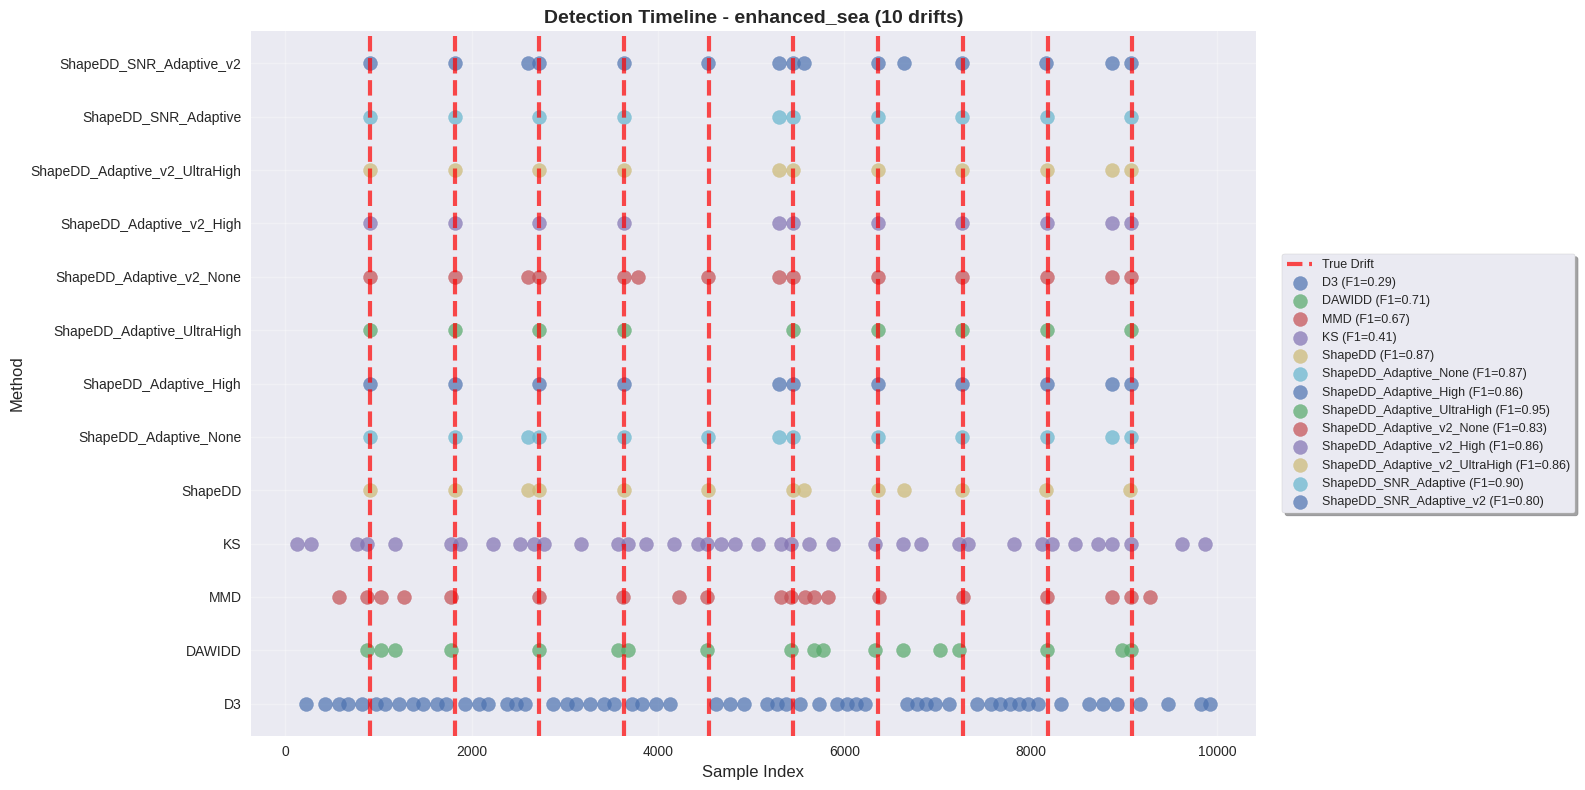

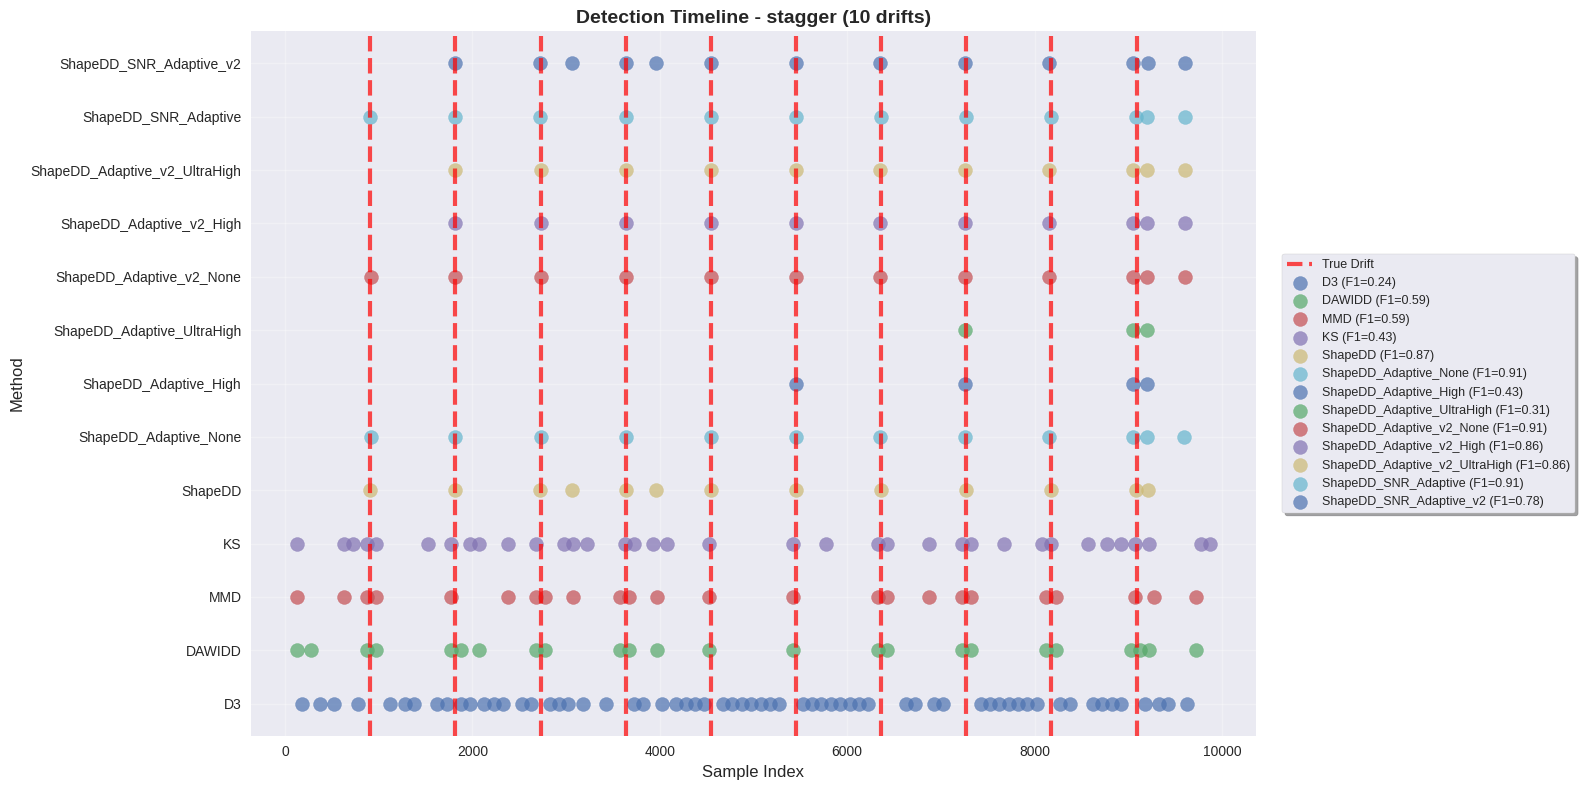

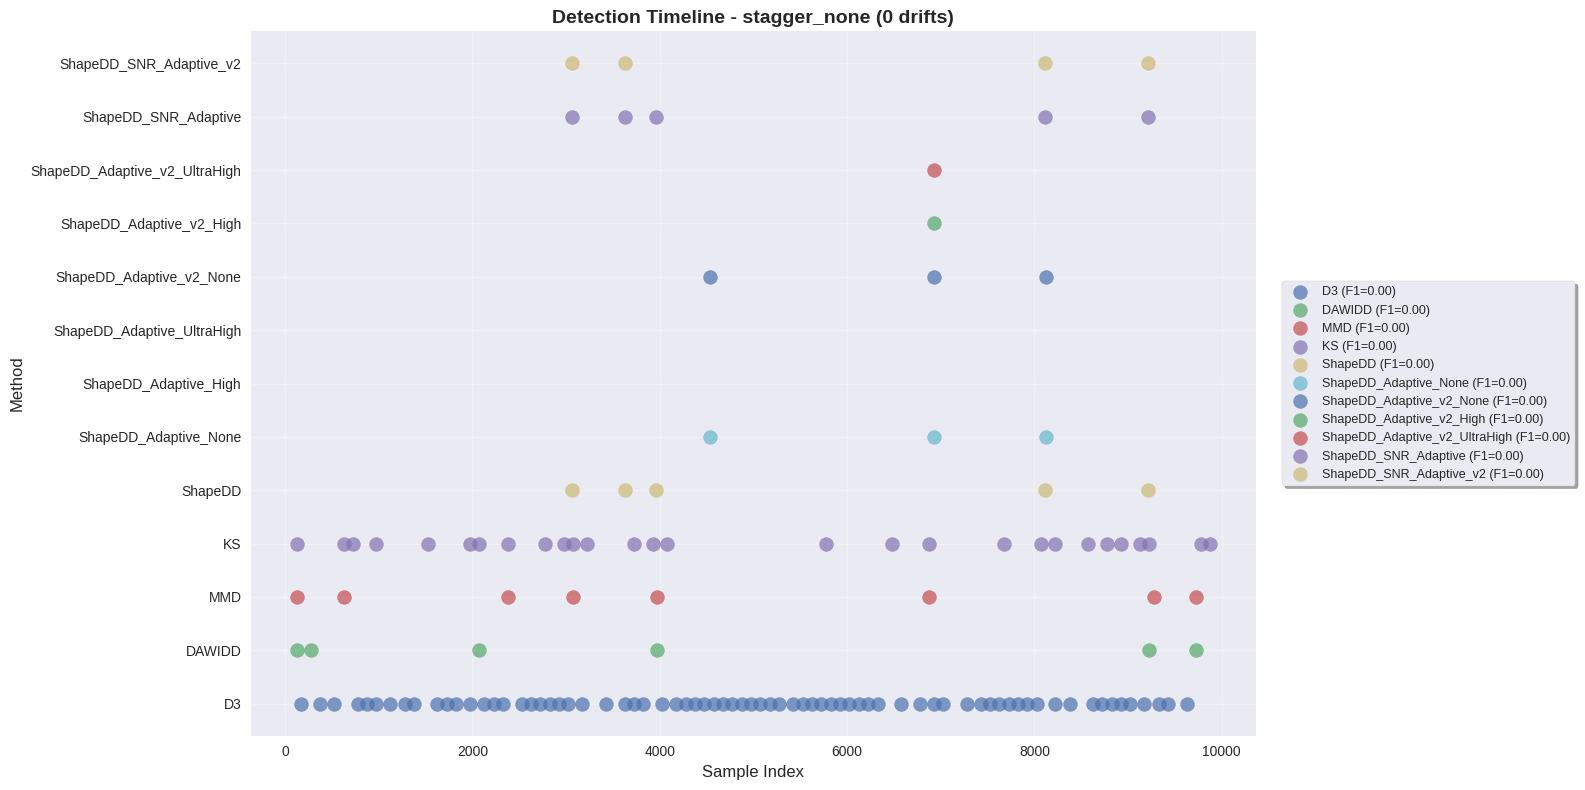

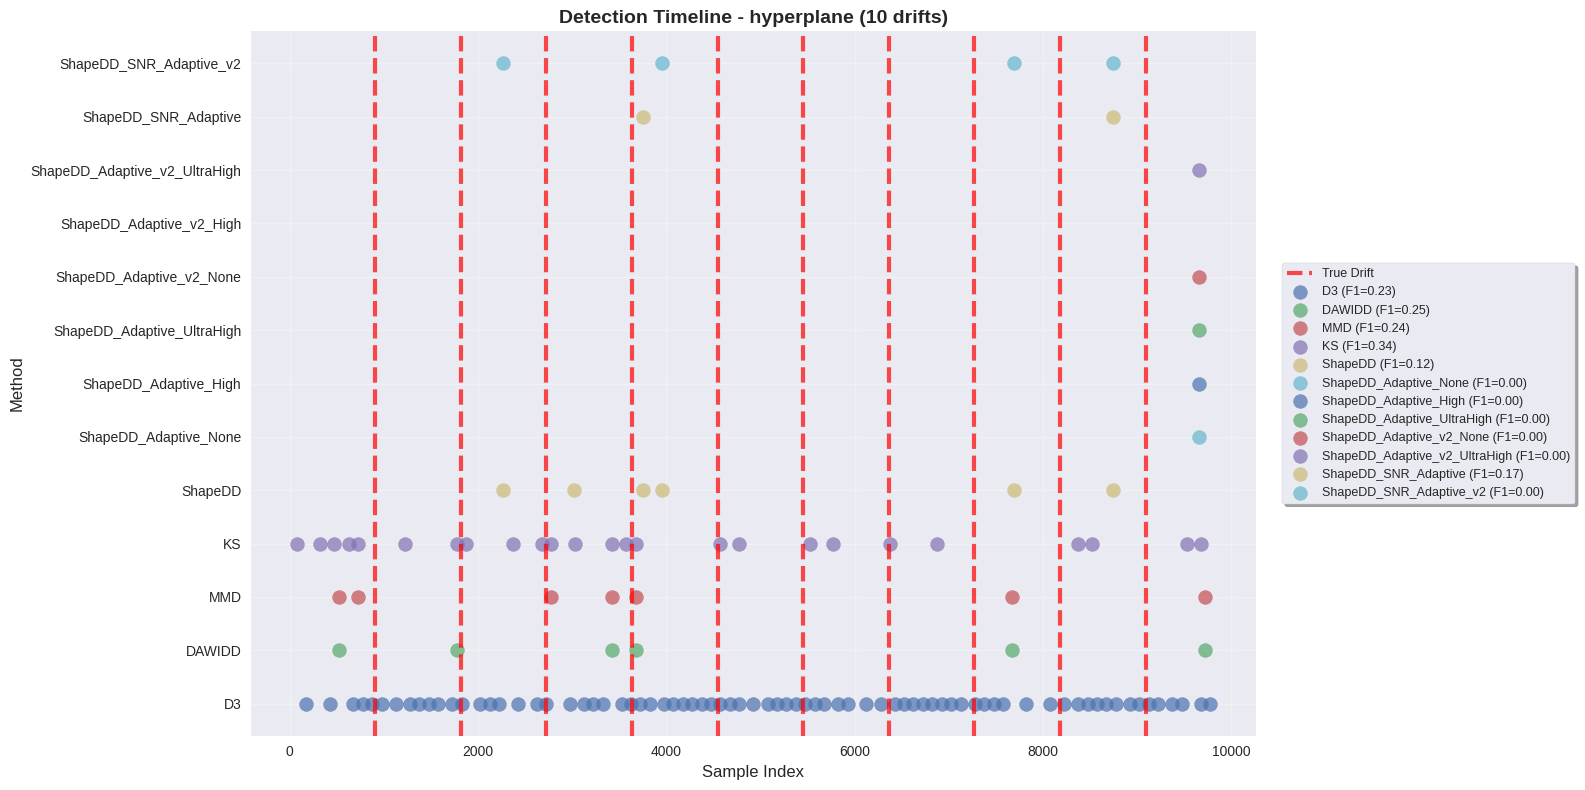

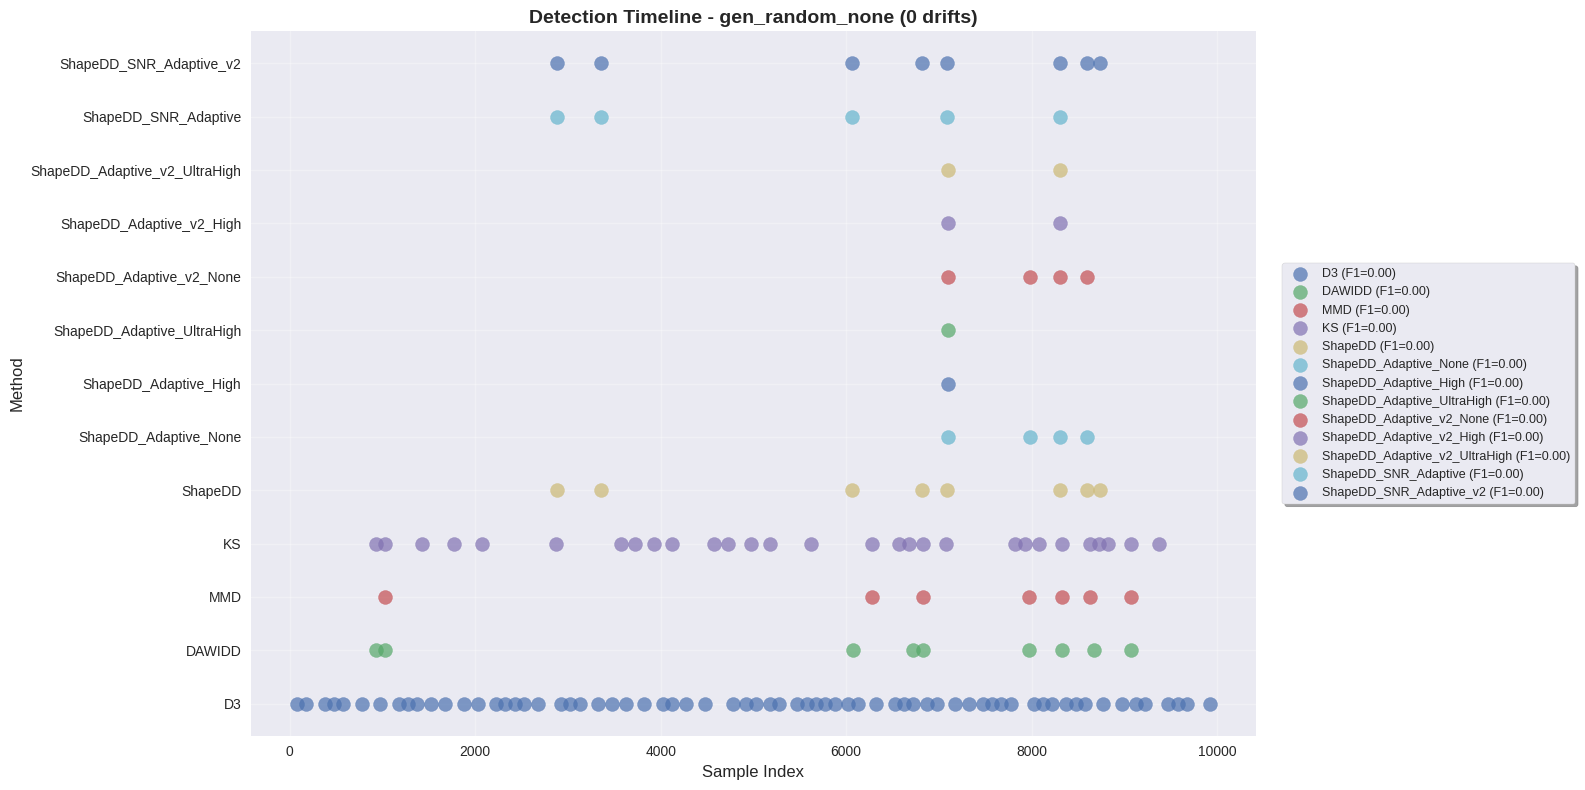

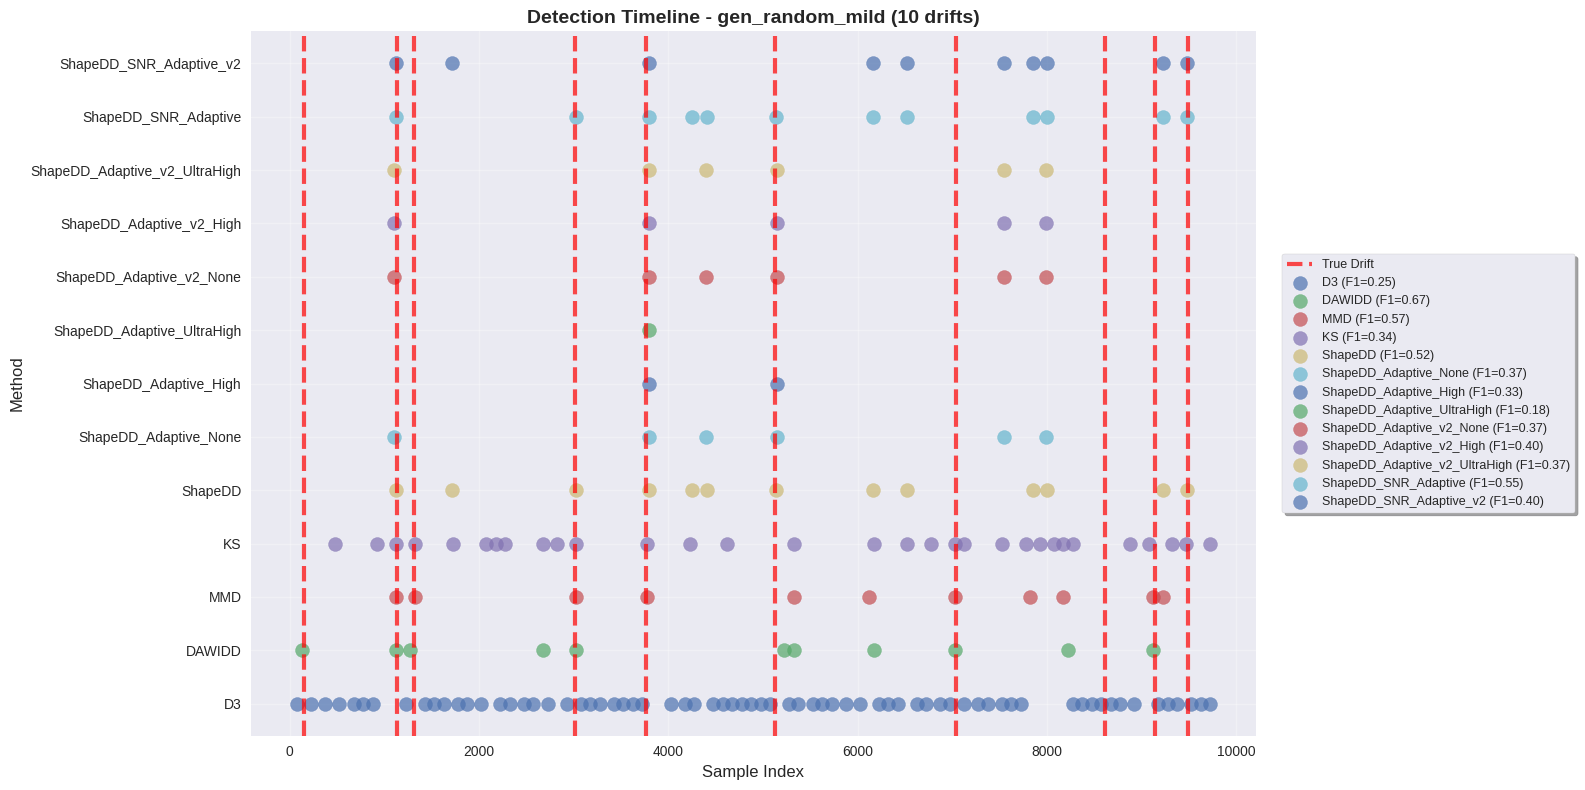

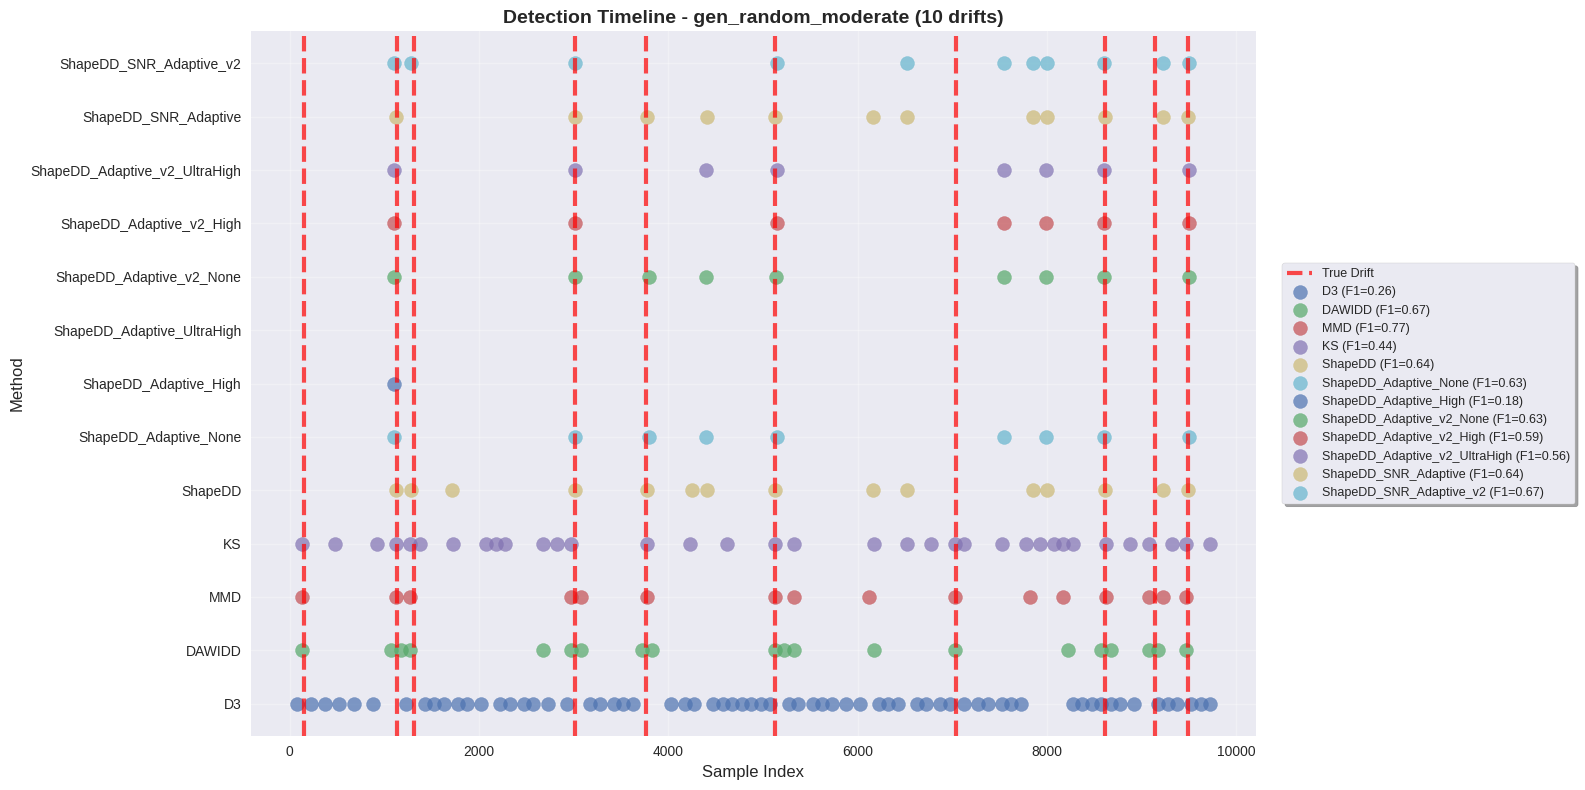

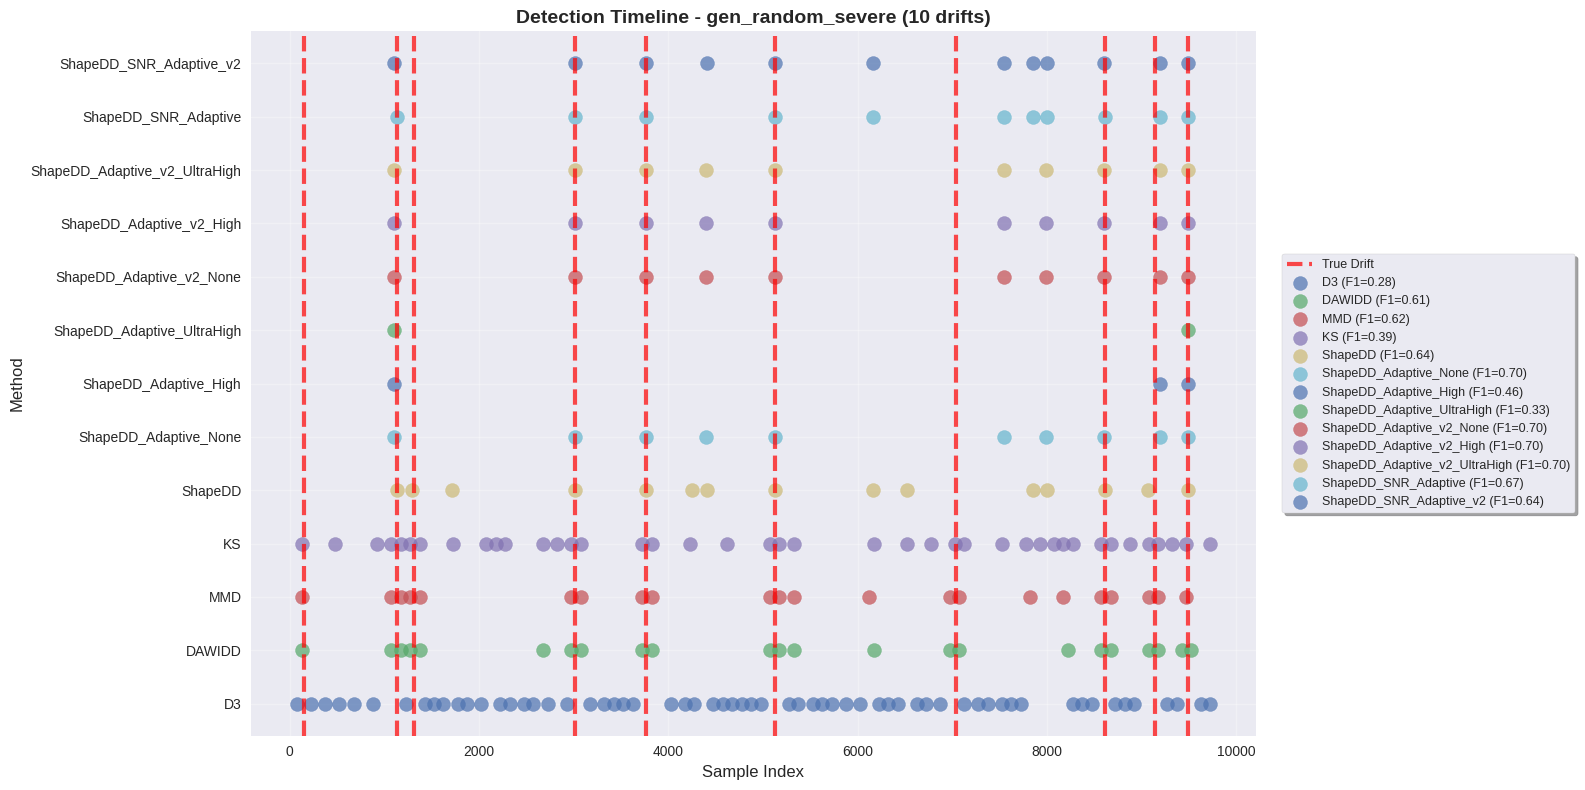

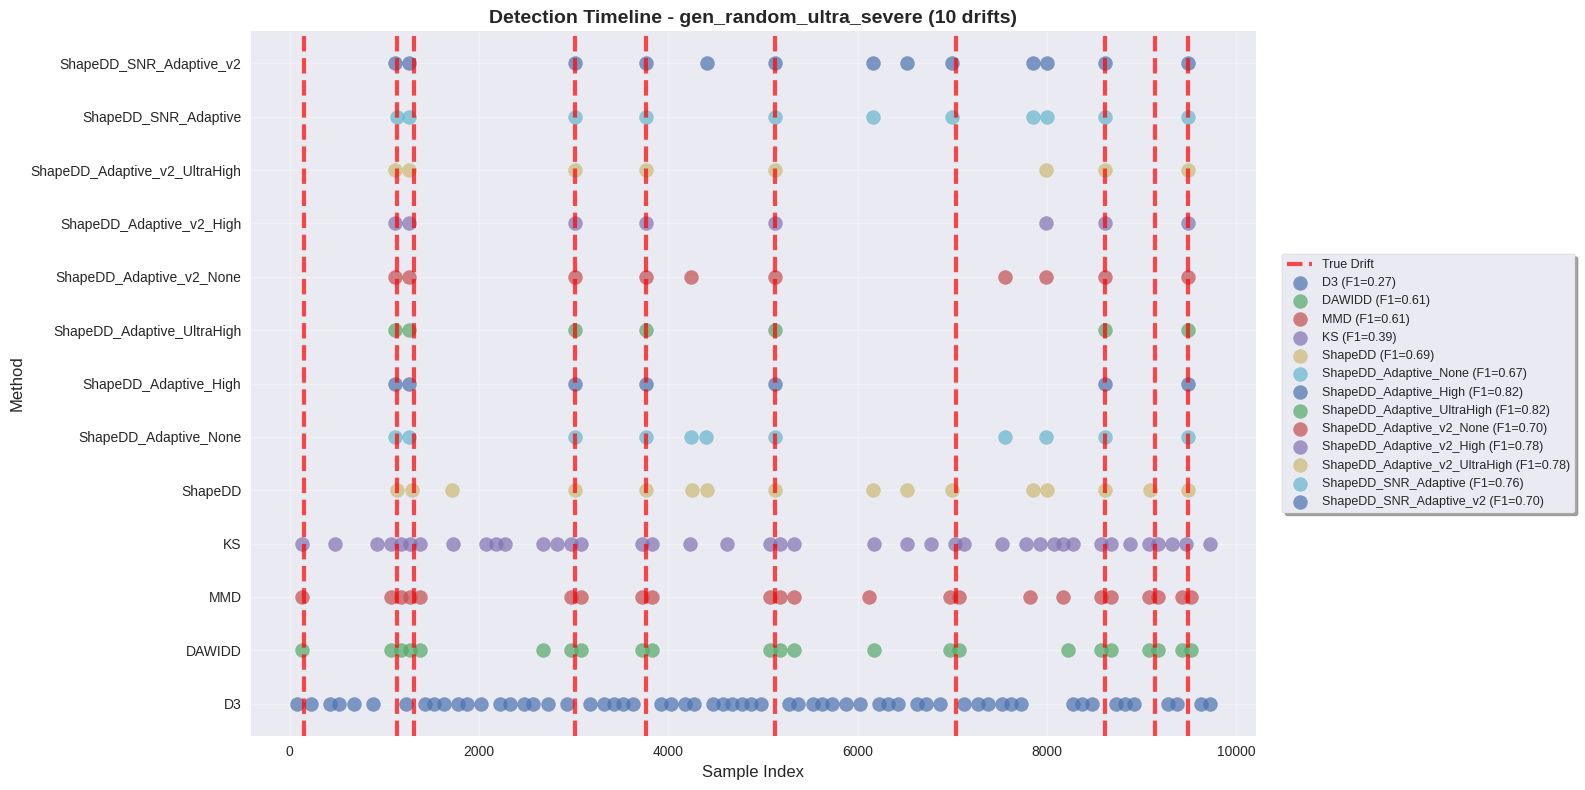

In [9]:
# ============================================================================
# SECTION 8: VISUALIZATION - DETECTION TIMELINES
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    datasets = results_df['Dataset'].unique()

    for dataset_name in datasets:
        dataset_results = [r for r in all_results if r['dataset'] == dataset_name]

        if not dataset_results:
            continue

        true_drifts = dataset_results[0]['drift_positions']
        n_drifts = len(true_drifts)

        fig, ax = plt.subplots(figsize=(16, 8))  # Wider figure for external legend

        # Plot true drifts
        for i, drift_pos in enumerate(true_drifts):
            ax.axvline(drift_pos, color='red', linestyle='--', linewidth=3,
                      alpha=0.7, label='True Drift' if i == 0 else '')

        # Plot detections
        for idx, result in enumerate(dataset_results):
            detections = result['detections']
            method = result['method']

            if detections:
                ax.scatter(detections, [idx]*len(detections), s=100, alpha=0.7,
                          label=f"{method} (F1={result['f1_score']:.2f})")

        ax.set_yticks(range(len(dataset_results)))
        ax.set_yticklabels([r['method'] for r in dataset_results])
        ax.set_xlabel('Sample Index', fontsize=12)
        ax.set_ylabel('Method', fontsize=12)
        ax.set_title(f'Detection Timeline - {dataset_name} ({n_drifts} drifts)',
                    fontsize=14, fontweight='bold')
        
        # Move legend outside plot area (to the right)
        ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9,
                 frameon=True, fancybox=True, shadow=True)
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()


Filtering datasets for heatmap visualization...
Total datasets: 10
Drift datasets (for heatmap): 8
  Excluded non-drift: ['stagger_none' 'gen_random_none']


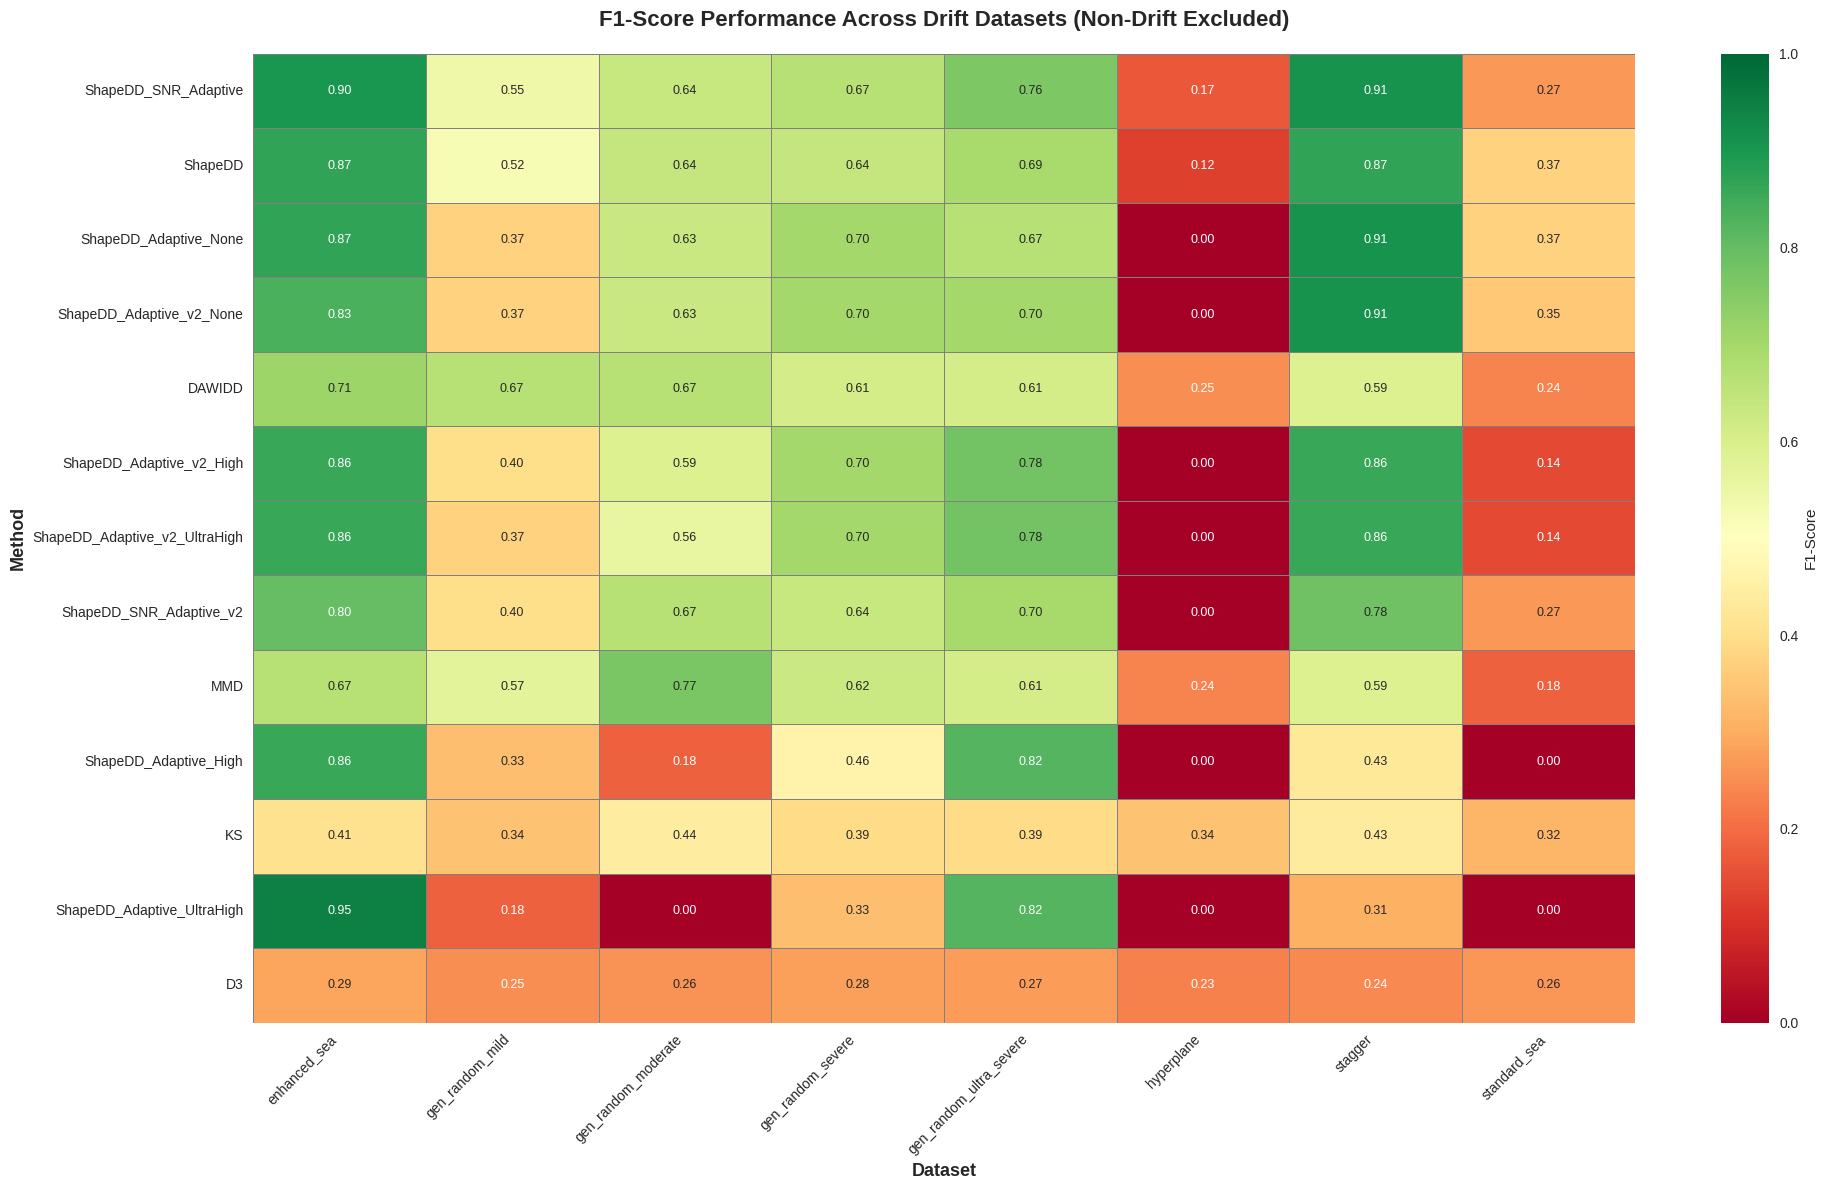

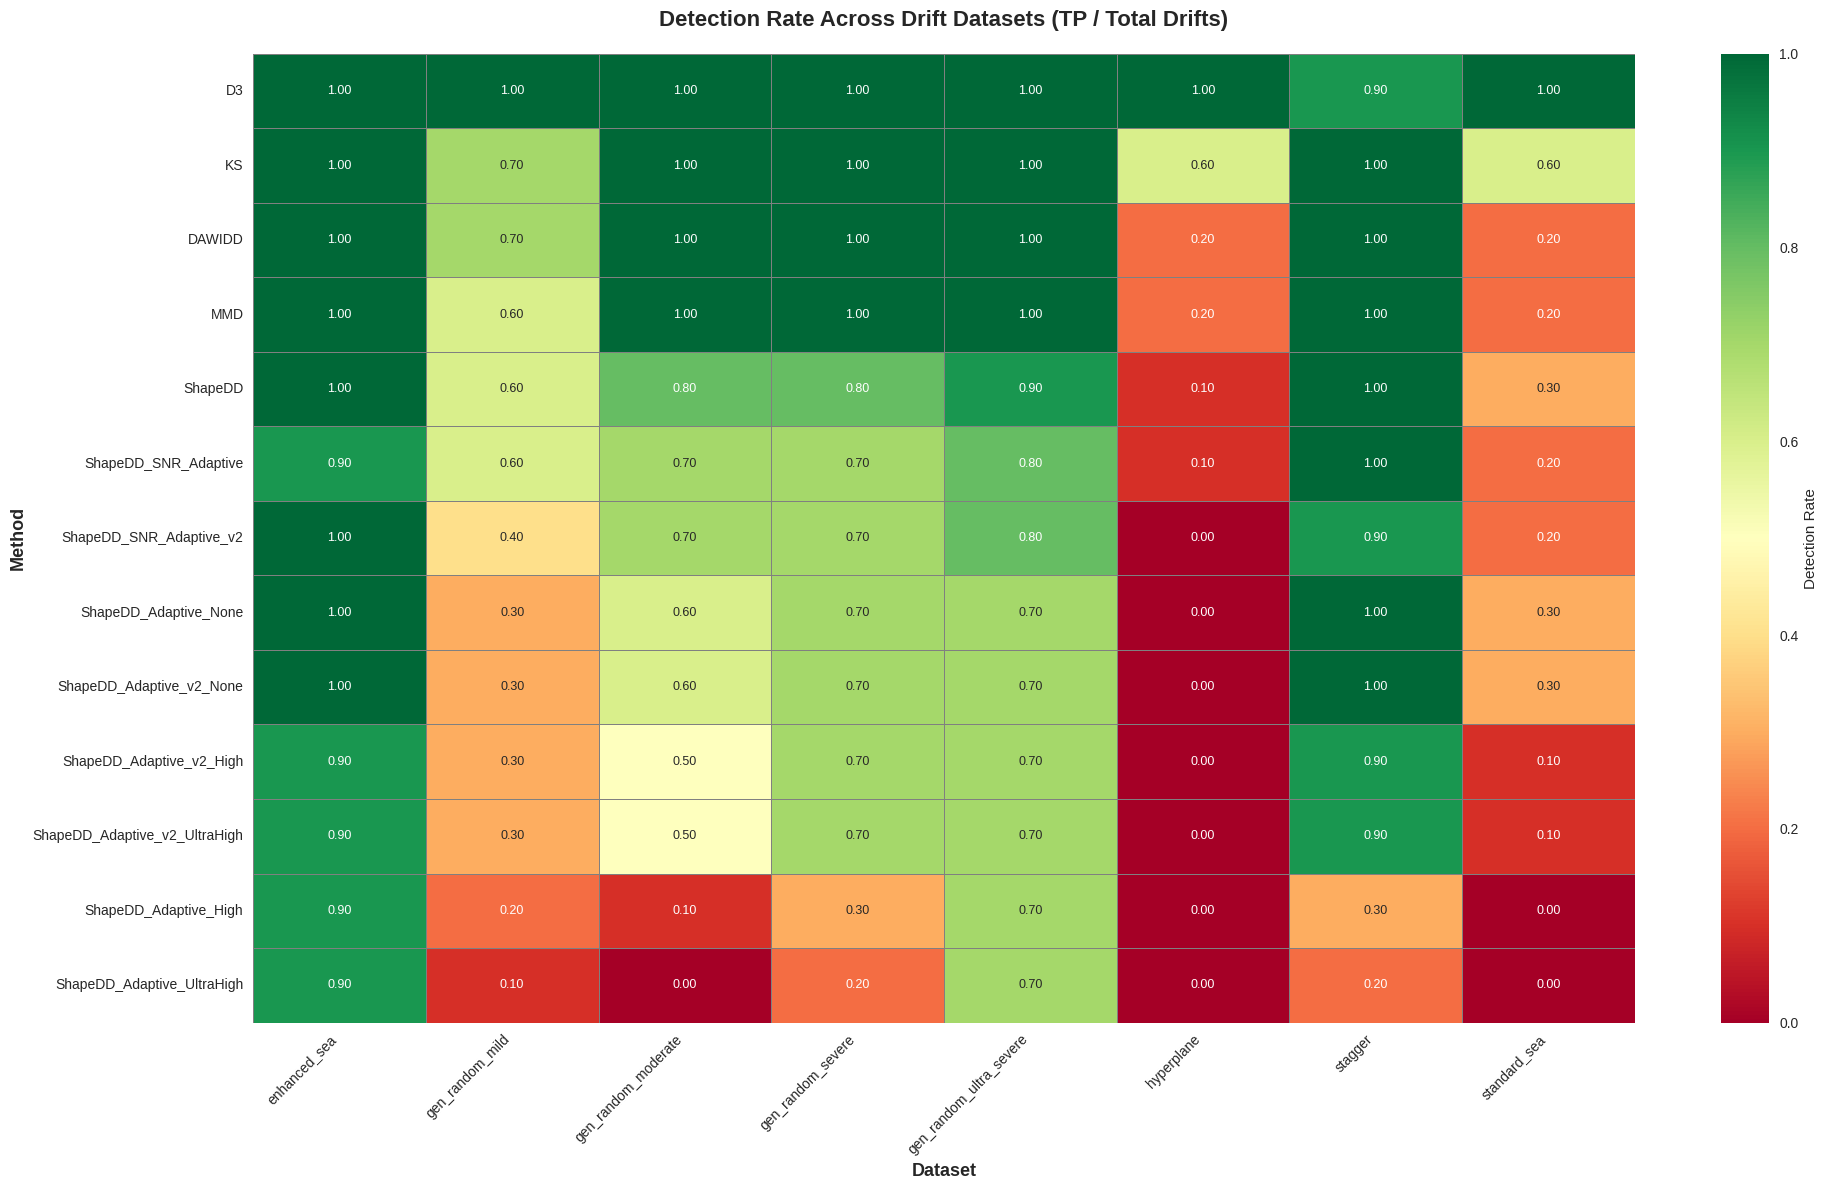

Heatmap visualizations created (F1-Score and Detection Rate - DRIFT DATASETS ONLY)


In [10]:
# ============================================================================
# SECTION 9: VISUALIZATION - PERFORMANCE HEATMAPS (Separate Plots)
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    # ========================================================================
    # FILTER: Use ONLY drift datasets for heatmaps
    # ========================================================================
    print("Filtering datasets for heatmap visualization...")
    print(f"Total datasets: {results_df['Dataset'].nunique()}")
    
    drift_datasets_for_plot = results_df[results_df['N_Drifts'] > 0].copy()
    print(f"Drift datasets (for heatmap): {drift_datasets_for_plot['Dataset'].nunique()}")
    print(f"  Excluded non-drift: {results_df[results_df['N_Drifts'] == 0]['Dataset'].unique()}")
    
    if len(drift_datasets_for_plot) == 0:
        print("⚠ No drift datasets available for heatmap!")
    else:
        # ========================================================================
        # HEATMAP 1: F1-Score Across DRIFT Datasets ONLY
        # ========================================================================
        
        fig, ax = plt.subplots(figsize=(20, 12))
        
        f1_pivot = drift_datasets_for_plot.pivot_table(values='F1', index='Method',
                                           columns='Dataset', aggfunc='mean')
        
        # Sort methods by average F1 score
        f1_pivot['_avg'] = f1_pivot.mean(axis=1)
        f1_pivot = f1_pivot.sort_values('_avg', ascending=False)
        f1_pivot = f1_pivot.drop('_avg', axis=1)
        
        sns.heatmap(f1_pivot, annot=True, fmt='.2f', cmap='RdYlGn',
                   vmin=0, vmax=1, cbar_kws={'label': 'F1-Score'},
                   linewidths=0.5, linecolor='gray',
                   annot_kws={'fontsize': 9}, ax=ax)
        
        ax.set_title('F1-Score Performance Across Drift Datasets (Non-Drift Excluded)', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Dataset', fontsize=13, fontweight='bold')
        ax.set_ylabel('Method', fontsize=13, fontweight='bold')
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # ========================================================================
        # HEATMAP 2: Detection Rate (Drift Datasets Only)
        # ========================================================================
        
        fig, ax = plt.subplots(figsize=(20, 12))
        
        dr_pivot = drift_datasets_for_plot.pivot_table(values='Detection_Rate', index='Method',
                                           columns='Dataset', aggfunc='mean')
        
        dr_pivot['_avg'] = dr_pivot.mean(axis=1)
        dr_pivot = dr_pivot.sort_values('_avg', ascending=False)
        dr_pivot = dr_pivot.drop('_avg', axis=1)
        
        sns.heatmap(dr_pivot, annot=True, fmt='.2f', cmap='RdYlGn',
                   vmin=0, vmax=1, cbar_kws={'label': 'Detection Rate'},
                   linewidths=0.5, linecolor='gray',
                   annot_kws={'fontsize': 9}, ax=ax)
        
        ax.set_title('Detection Rate Across Drift Datasets (TP / Total Drifts)', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Dataset', fontsize=13, fontweight='bold')
        ax.set_ylabel('Method', fontsize=13, fontweight='bold')
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
        
        plt.tight_layout()
        plt.show()

print("Heatmap visualizations created (F1-Score and Detection Rate - DRIFT DATASETS ONLY)")


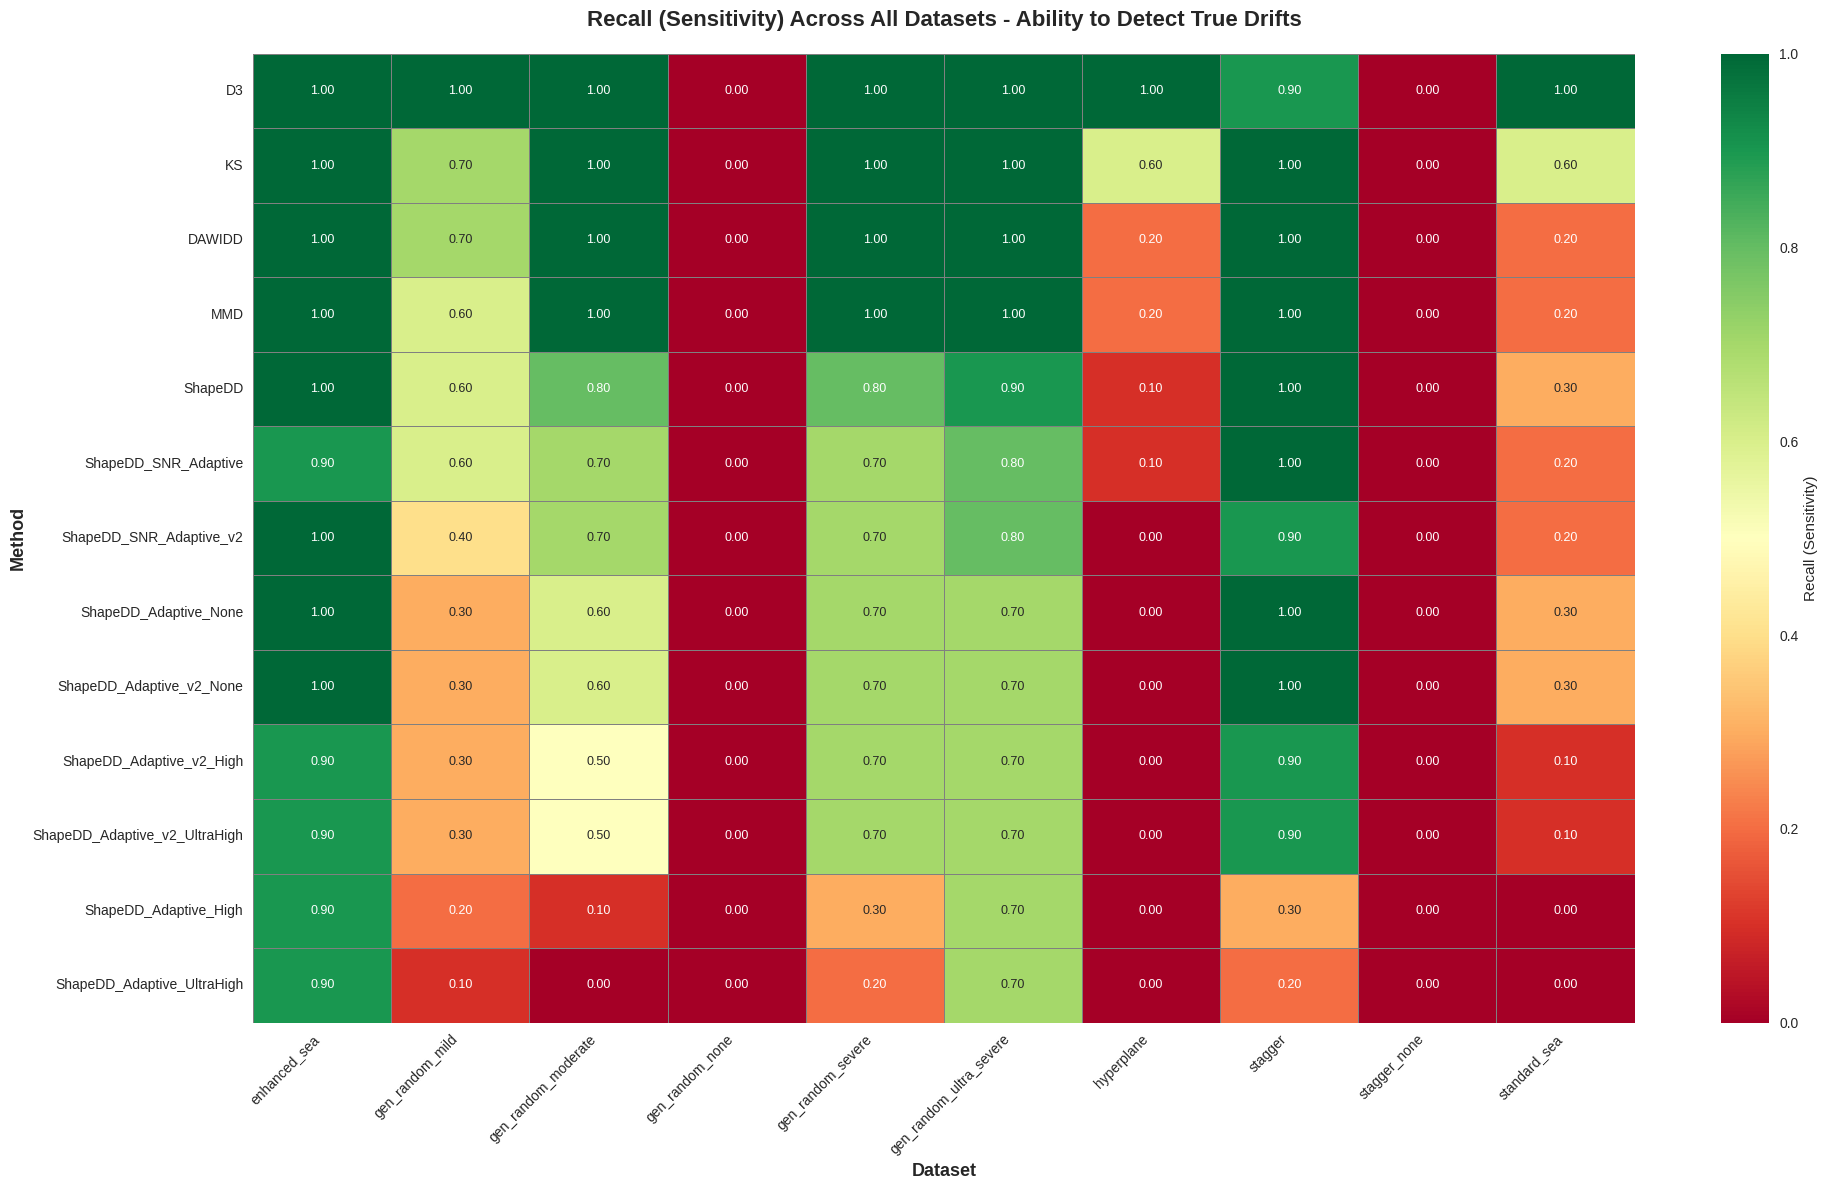

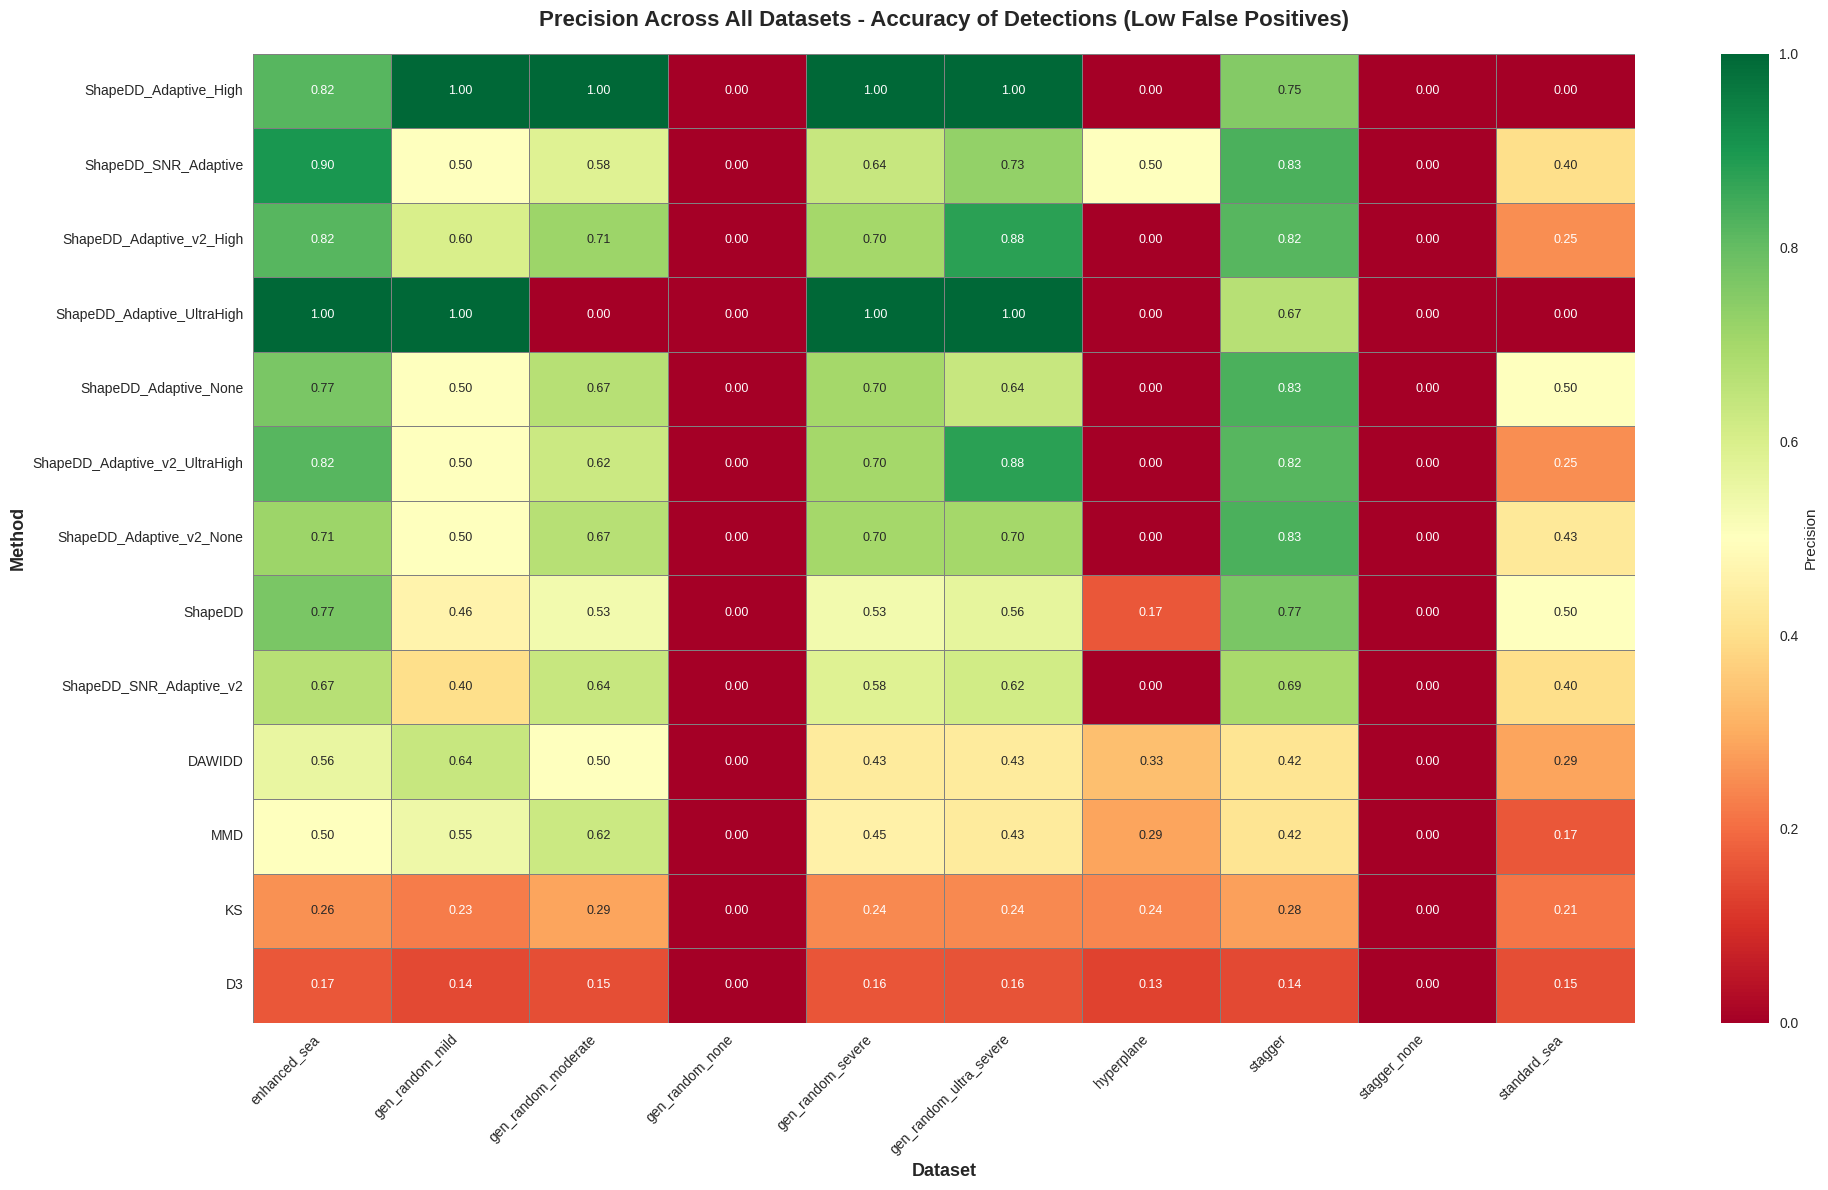

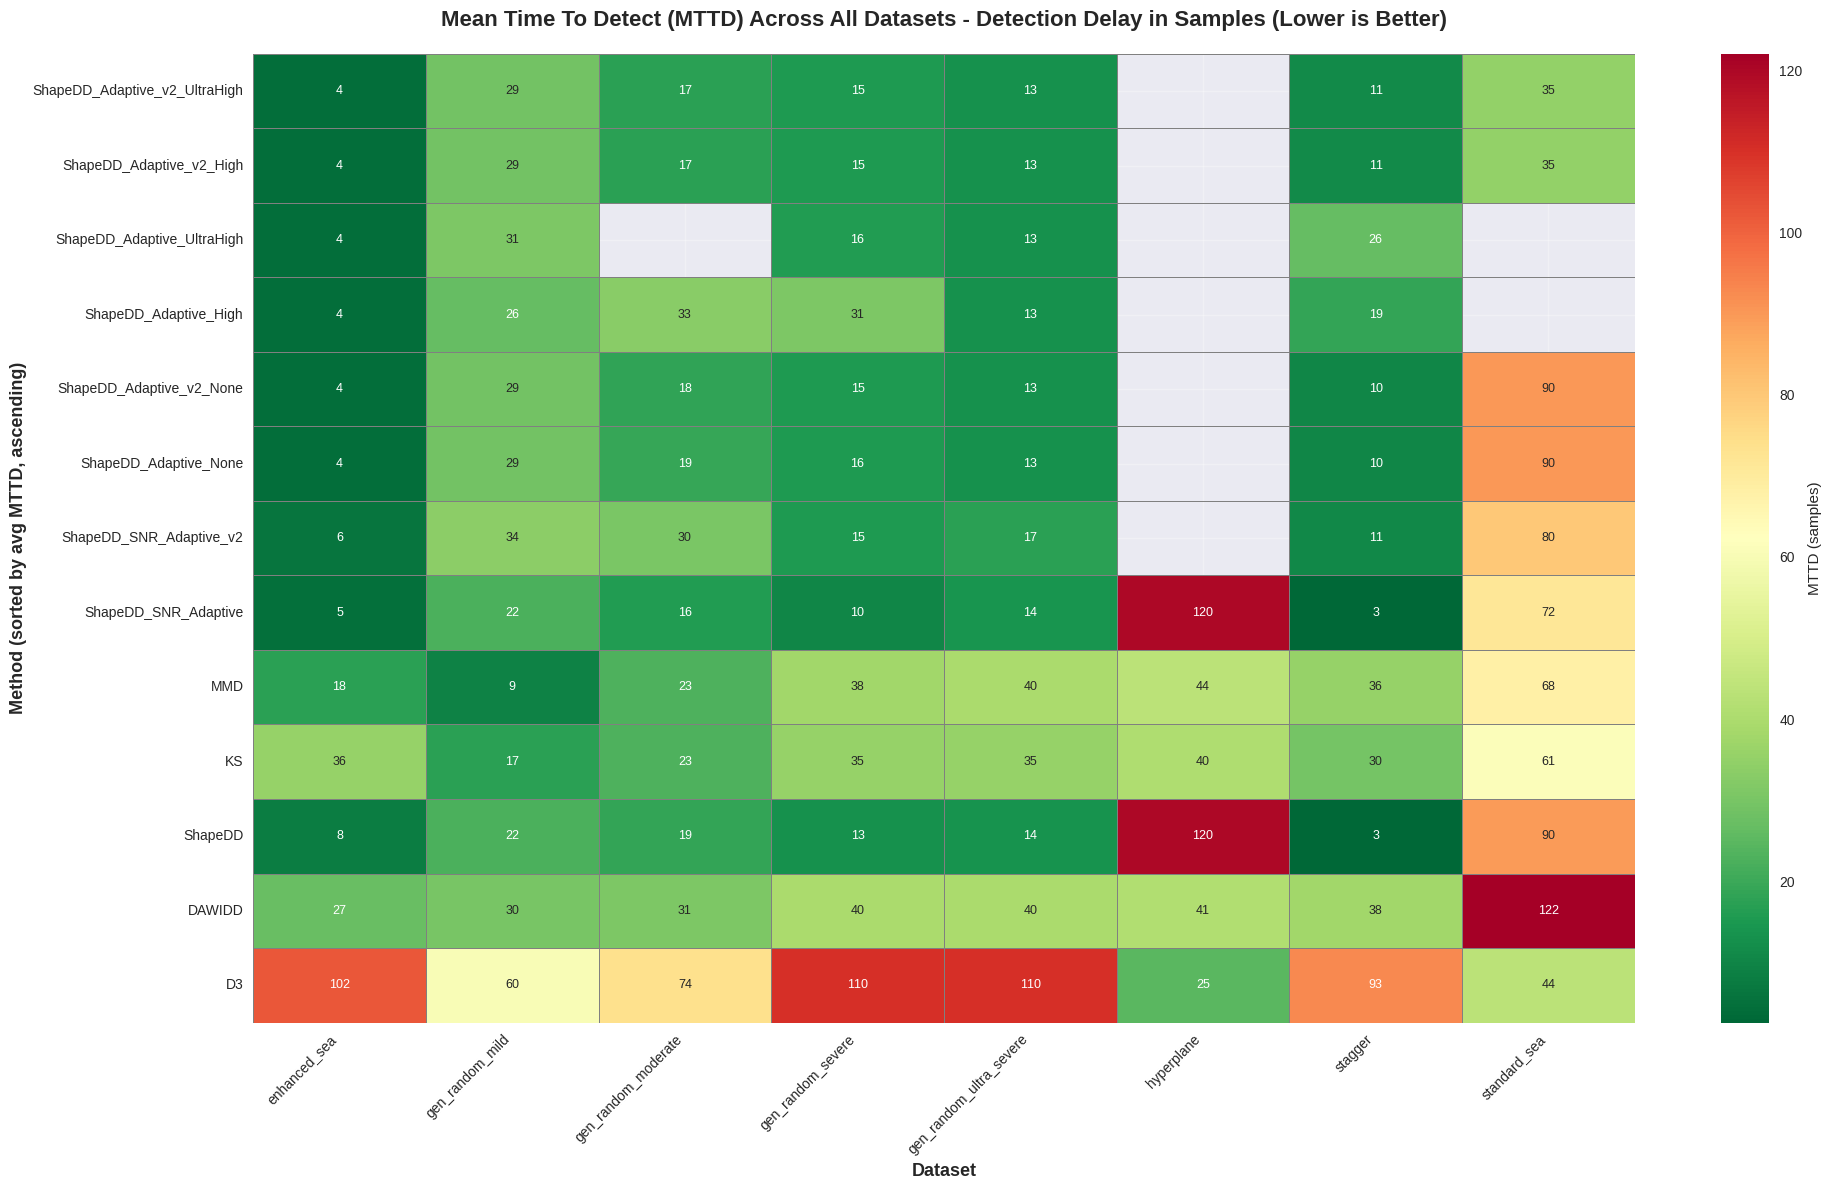

Heatmap visualizations created (Recall, Precision, and MTTD)


In [11]:
# ============================================================================
# SECTION 10: VISUALIZATION - RECALL AND MTTD HEATMAPS (Separate Plots)
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    # ========================================================================
    # HEATMAP 3: Recall (Sensitivity) Across All Datasets
    # ========================================================================
    
    fig, ax = plt.subplots(figsize=(20, 12))  # Large figure for better readability
    
    recall_pivot = results_df.pivot_table(values='Recall', index='Method',
                                          columns='Dataset', aggfunc='mean')
    
    # Sort methods by average recall
    recall_pivot['_avg'] = recall_pivot.mean(axis=1)
    recall_pivot = recall_pivot.sort_values('_avg', ascending=False)
    recall_pivot = recall_pivot.drop('_avg', axis=1)
    
    sns.heatmap(recall_pivot, annot=True, fmt='.2f', cmap='RdYlGn',
               vmin=0, vmax=1, cbar_kws={'label': 'Recall (Sensitivity)'},
               linewidths=0.5, linecolor='gray',
               annot_kws={'fontsize': 9}, ax=ax)
    
    ax.set_title('Recall (Sensitivity) Across All Datasets - Ability to Detect True Drifts', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Dataset', fontsize=13, fontweight='bold')
    ax.set_ylabel('Method', fontsize=13, fontweight='bold')
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # HEATMAP 4: Precision Across All Datasets
    # ========================================================================
    
    fig, ax = plt.subplots(figsize=(20, 12))  # Large figure for better readability
    
    precision_pivot = results_df.pivot_table(values='Precision', index='Method',
                                             columns='Dataset', aggfunc='mean')
    
    # Sort methods by average precision
    precision_pivot['_avg'] = precision_pivot.mean(axis=1)
    precision_pivot = precision_pivot.sort_values('_avg', ascending=False)
    precision_pivot = precision_pivot.drop('_avg', axis=1)
    
    sns.heatmap(precision_pivot, annot=True, fmt='.2f', cmap='RdYlGn',
               vmin=0, vmax=1, cbar_kws={'label': 'Precision'},
               linewidths=0.5, linecolor='gray',
               annot_kws={'fontsize': 9}, ax=ax)
    
    ax.set_title('Precision Across All Datasets - Accuracy of Detections (Low False Positives)', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Dataset', fontsize=13, fontweight='bold')
    ax.set_ylabel('Method', fontsize=13, fontweight='bold')
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # HEATMAP 5: Mean Time To Detect (MTTD) Across All Datasets
    # ========================================================================
    
    fig, ax = plt.subplots(figsize=(20, 12))  # Large figure for better readability
    
    mttd_pivot = results_df.pivot_table(values='MTTD', index='Method',
                                        columns='Dataset', aggfunc='mean')
    
    # Sort methods by average MTTD (ascending - lower is better)
    mttd_pivot['_avg'] = mttd_pivot.mean(axis=1)
    mttd_pivot = mttd_pivot.sort_values('_avg', ascending=True)
    mttd_pivot = mttd_pivot.drop('_avg', axis=1)
    
    # Use reverse colormap (lower MTTD is better = greener)
    sns.heatmap(mttd_pivot, annot=True, fmt='.0f', cmap='RdYlGn_r',
               cbar_kws={'label': 'MTTD (samples)'},
               linewidths=0.5, linecolor='gray',
               annot_kws={'fontsize': 9}, ax=ax)
    
    ax.set_title('Mean Time To Detect (MTTD) Across All Datasets - Detection Delay in Samples (Lower is Better)', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Dataset', fontsize=13, fontweight='bold')
    ax.set_ylabel('Method (sorted by avg MTTD, ascending)', fontsize=13, fontweight='bold')
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    
    plt.tight_layout()
    plt.show()

print("Heatmap visualizations created (Recall, Precision, and MTTD)")


In [12]:
# ============================================================================
# SECTION 11: EXPORT VISUALIZATIONS FOR THESIS (ALL IN ENGLISH)
# ============================================================================

print("\n" + "="*80)
print("GENERATING ALL THESIS VISUALIZATIONS (ENGLISH LABELS)")
print("="*80)
print()
print("This cell will:")
print("  1. Extract actual F1 scores from results_df")
print("  2. Generate 7 visualizations with ENGLISH labels")
print("     - 6 performance visualizations")
print("     - 1 architecture diagram")
print("  3. Save to ../../report/latex/image/")
print("  4. Auto-update when you re-run the notebook")
print()
print("Running master visualization script...")
print("="*80)
print()

# Run the master script (generates all 7 figures)
%run generate_all_figures.py

print()
print("="*80)
print("✓ ALL THESIS VISUALIZATIONS COMPLETE!")
print("="*80)
print()
print("Generated 7 figures with ENGLISH labels:")
print("  1. strategy_selection.png      - Strategy distribution")
print("  2. f1_comparison.png           - Performance comparison")
print("  3. optimization_comparison.png - Parameter optimization")
print("  4. method_ranking.png          - Method ranking table")
print("  5. threshold_sensitivity.png   - Sensitivity analysis")
print("  6. buffer_dilution.png         - Buffer dilution effect")
print("  7. snr_adaptive_architecture.png - System architecture")
print()
print("Next steps:")
print("  1. Check ../../report/latex/image/ for all 7 figures")
print("  2. Verify extracted F1 scores match thesis (0.697, 66.2%, rank 4/18)")
print("  3. Compile thesis to see all figures in context")
print()



GENERATING ALL THESIS VISUALIZATIONS (ENGLISH LABELS)

This cell will:
  1. Extract actual F1 scores from results_df
  2. Generate 7 visualizations with ENGLISH labels
     - 6 performance visualizations
     - 1 architecture diagram
  3. Save to ../../report/latex/image/
  4. Auto-update when you re-run the notebook

Running master visualization script...

GENERATING ALL THESIS FIGURES (ENGLISH LABELS)

Step 1/2: Generating performance visualizations (6 figures)...
--------------------------------------------------------------------------------
Creating All Thesis Visualizations (Auto-Extract from Notebook)

📊 Extracting results from notebook...
   Attempting to extract from notebook JSON...
   ⚠️  Could not extract from notebook JSON
   Using fallback: Load from summary output or hardcoded values
   Attempting to execute notebook and extract variables...
   ✓ Loaded results_df with 130 rows
   ✓ Successfully loaded results_df with 130 rows
   ✓ Aggregated to 13 methods

Top 5 Method

In [ ]:
# ============================================================================
# SECTION 12: PUBLICATION-QUALITY SETUP
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

# Create output directory for publication-ready figures
output_dir = Path("./publication_figures")
output_dir.mkdir(exist_ok=True)

# Publication-quality matplotlib settings
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'text.usetex': False,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'axes.grid': False,
    'axes.spines.top': True,
    'axes.spines.right': True,
})

sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.3})

print("✓ Publication settings configured")
print(f"✓ Output directory: {output_dir.absolute()}")
print(f"✓ DPI: 300 (publication quality)")
print(f"✓ Font: Times New Roman/Serif")


In [ ]:
# ============================================================================
# SECTION 13: PUBLICATION TABLE I - LaTeX Format
# ============================================================================

if len(all_results) == 0:
    print("⚠ Run benchmark first (Cell 6)")
else:
    print("\n" + "="*100)
    print("TABLE I: COMPREHENSIVE PERFORMANCE - LaTeX FORMAT")
    print("="*100)

    drift_results_df = results_df[results_df['N_Drifts'] > 0].copy()

    method_stats = drift_results_df.groupby('Method').agg({
        'F1': ['mean', 'std'],
        'Precision': 'mean',
        'Recall': 'mean',
        'MTTD': 'mean',
        'TP': 'sum',
        'FP': 'sum',
        'FN': 'sum'
    }).round(4)

    pub_table = pd.DataFrame({
        'Method': method_stats.index,
        'F1': method_stats[('F1', 'mean')],
        'F1_std': method_stats[('F1', 'std')],
        'Precision': method_stats[('Precision', 'mean')],
        'Recall': method_stats[('Recall', 'mean')],
        'MTTD': method_stats[('MTTD', 'mean')].fillna(0).astype(int),
        'TP': method_stats[('TP', 'sum')].astype(int),
        'FP': method_stats[('FP', 'sum')].astype(int),
        'FN': method_stats[('FN', 'sum')].astype(int)
    })

    pub_table = pub_table.sort_values('F1', ascending=False).reset_index(drop=True)
    pub_table['F1_formatted'] = pub_table.apply(
        lambda row: f"${row['F1']:.3f} \\pm {row['F1_std']:.3f}$", axis=1
    )

    latex_table = pub_table[['Method', 'F1_formatted', 'Precision', 'Recall', 'MTTD', 'TP', 'FP', 'FN']].copy()
    latex_table.columns = ['Method', 'F1 ($\\mu \\pm \\sigma$)', 'Precision', 'Recall', 'MTTD', 'TP', 'FP', 'FN']

    for col in ['Precision', 'Recall']:
        latex_table[col] = latex_table[col].apply(lambda x: f"{x:.3f}")

    latex_output = latex_table.to_latex(
        index=False,
        escape=False,
        column_format='l' + 'c' * (len(latex_table.columns) - 1),
        caption='Comprehensive drift detection performance across drift datasets.',
        label='tab:comprehensive_performance',
        position='htbp'
    )

    latex_file = output_dir / "table_I_comprehensive_performance.tex"
    with open(latex_file, 'w') as f:
        f.write(latex_output)

    print(f"✓ LaTeX table saved: {latex_file}")
    print("\nPreview (first 5 methods):")
    print(latex_table.head().to_string())
    print("\n" + "="*100)


In [ ]:
# ============================================================================
# SECTION 14: PUBLICATION TABLE II - Performance by Drift Type
# ============================================================================

if len(all_results) == 0:
    print("⚠ Run benchmark first")
else:
    print("\n" + "="*100)
    print("TABLE II: PERFORMANCE BY DRIFT TYPE - LaTeX FORMAT")
    print("="*100)

    def categorize_drift_type(dataset_name):
        gradual_keywords = ['gradual', 'circles', 'agrawal_gradual', 'hyperplane_gradual']
        incremental_keywords = ['rbf', 'hyperplane']
        stationary_keywords = ['none']
        dataset_lower = dataset_name.lower()
        if any(k in dataset_lower for k in stationary_keywords):
            return 'Stationary'
        elif any(k in dataset_lower for k in gradual_keywords):
            return 'Gradual'
        elif any(k in dataset_lower for k in incremental_keywords):
            return 'Incremental'
        elif 'electricity' in dataset_lower:
            return 'Real-World'
        else:
            return 'Sudden'

    results_df['Drift_Type'] = results_df['Dataset'].apply(categorize_drift_type)

    drift_type_stats = results_df.groupby(['Method', 'Drift_Type']).agg({
        'F1': 'mean',
        'Precision': 'mean',
        'Recall': 'mean',
        'MTTD': 'mean'
    }).reset_index()

    f1_by_type = drift_type_stats.pivot(index='Method', columns='Drift_Type', values='F1')
    drift_cols = [c for c in f1_by_type.columns if c != 'Stationary']
    f1_by_type['Avg'] = f1_by_type[drift_cols].mean(axis=1)
    f1_by_type = f1_by_type.sort_values('Avg', ascending=False)

    latex_output_drift = f1_by_type.to_latex(
        float_format='%.3f',
        caption='F1-score performance stratified by drift type.',
        label='tab:performance_by_drift_type',
        column_format='l' + 'c' * len(f1_by_type.columns),
        position='htbp'
    )

    latex_file_drift = output_dir / "table_II_performance_by_drift_type.tex"
    with open(latex_file_drift, 'w') as f:
        f.write(latex_output_drift)

    print(f"✓ LaTeX table saved: {latex_file_drift}")
    print("\nPreview:")
    print(f1_by_type.to_string())
    print("="*100)


In [ ]:
# ============================================================================
# SECTION 15: PUBLICATION FIGURE 1 - F1-Score Heatmap
# ============================================================================

if len(all_results) == 0:
    print("⚠ Run benchmark first")
else:
    print("Generating Figure 1: F1-Score Heatmap (sorted by category)...")

    drift_datasets = results_df[results_df['N_Drifts'] > 0].copy()
    f1_pivot = drift_datasets.pivot_table(values='F1', index='Method', columns='Dataset', aggfunc='mean')
    
    # Sort methods by average F1
    f1_pivot['_avg'] = f1_pivot.mean(axis=1)
    f1_pivot = f1_pivot.sort_values('_avg', ascending=False).drop('_avg', axis=1)
    
    # Sort datasets by category: Sudden > Gradual > Incremental > Real-World
    def categorize_drift_type(dataset_name):
        gradual_keywords = ['gradual', 'circles']
        incremental_keywords = ['rbf']
        dataset_lower = dataset_name.lower()
        if any(k in dataset_lower for k in gradual_keywords):
            return 'B_Gradual'
        elif any(k in dataset_lower for k in incremental_keywords):
            return 'C_Incremental'
        elif 'electricity' in dataset_lower:
            return 'D_Real-World'
        else:
            return 'A_Sudden'
    
    dataset_categories = {col: categorize_drift_type(col) for col in f1_pivot.columns}
    sorted_columns = sorted(f1_pivot.columns, key=lambda x: (dataset_categories[x], x))
    f1_pivot = f1_pivot[sorted_columns]

    fig, ax = plt.subplots(figsize=(18, 11))
    sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
               cbar_kws={'label': 'F1-Score', 'shrink': 0.8, 'aspect': 20},
               linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)

    ax.set_title('F1-Score Performance (Grouped by Drift Type: Sudden | Gradual | Incremental | Real-World)',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Dataset (grouped by category)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Detection Method', fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    
    # Add vertical lines to separate categories
    prev_cat = None
    for idx, col in enumerate(f1_pivot.columns):
        cat = dataset_categories[col]
        if prev_cat is not None and cat != prev_cat:
            ax.axvline(x=idx, color='black', linewidth=2, linestyle='--', alpha=0.5)
        prev_cat = cat

    plt.tight_layout()

    for fmt in ['png', 'pdf']:
        filepath = output_dir / f"figure_1_f1_heatmap.{fmt}"
        plt.savefig(filepath, dpi=300, bbox_inches='tight', format=fmt)
        print(f"✓ Saved: {filepath}")

    plt.show()
    print("Figure 1 complete (datasets grouped by category)\n")


In [ ]:
# ============================================================================
# SECTION 16: PUBLICATION FIGURE 2 - Precision Heatmap
# ============================================================================

if len(all_results) == 0:
    print("⚠ Run benchmark first")
else:
    print("Generating Figure 2: Precision Heatmap (sorted by category)...")

    precision_pivot = results_df.pivot_table(values='Precision', index='Method', columns='Dataset', aggfunc='mean')
    
    # Sort methods by average precision
    precision_pivot['_avg'] = precision_pivot.mean(axis=1)
    precision_pivot = precision_pivot.sort_values('_avg', ascending=False).drop('_avg', axis=1)
    
    # Sort datasets by category
    def categorize_drift_type(dataset_name):
        gradual_keywords = ['gradual', 'circles']
        incremental_keywords = ['rbf']
        stationary_keywords = ['none']
        dataset_lower = dataset_name.lower()
        if any(k in dataset_lower for k in stationary_keywords):
            return 'E_Stationary'
        elif any(k in dataset_lower for k in gradual_keywords):
            return 'B_Gradual'
        elif any(k in dataset_lower for k in incremental_keywords):
            return 'C_Incremental'
        elif 'electricity' in dataset_lower:
            return 'D_Real-World'
        else:
            return 'A_Sudden'
    
    dataset_categories = {col: categorize_drift_type(col) for col in precision_pivot.columns}
    sorted_columns = sorted(precision_pivot.columns, key=lambda x: (dataset_categories[x], x))
    precision_pivot = precision_pivot[sorted_columns]

    fig, ax = plt.subplots(figsize=(18, 11))
    sns.heatmap(precision_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
               cbar_kws={'label': 'Precision', 'shrink': 0.8, 'aspect': 20},
               linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)

    ax.set_title('Precision Across Methods (Grouped: Sudden | Gradual | Incremental | Real-World | Stationary)',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Dataset (grouped by category)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Detection Method', fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    
    # Add vertical lines to separate categories
    prev_cat = None
    for idx, col in enumerate(precision_pivot.columns):
        cat = dataset_categories[col]
        if prev_cat is not None and cat != prev_cat:
            ax.axvline(x=idx, color='black', linewidth=2, linestyle='--', alpha=0.5)
        prev_cat = cat

    plt.tight_layout()

    for fmt in ['png', 'pdf']:
        filepath = output_dir / f"figure_2_precision_heatmap.{fmt}"
        plt.savefig(filepath, dpi=300, bbox_inches='tight', format=fmt)
        print(f"✓ Saved: {filepath}")

    plt.show()
    print("Figure 2 complete (datasets grouped by category)\n")


In [ ]:
# ============================================================================
# SECTION 17: PUBLICATION FIGURE 3 - Recall Heatmap
# ============================================================================

if len(all_results) == 0:
    print("⚠ Run benchmark first")
else:
    print("Generating Figure 3: Recall Heatmap (sorted by category)...")

    recall_pivot = results_df.pivot_table(values='Recall', index='Method', columns='Dataset', aggfunc='mean')
    
    # Sort methods by average recall
    recall_pivot['_avg'] = recall_pivot.mean(axis=1)
    recall_pivot = recall_pivot.sort_values('_avg', ascending=False).drop('_avg', axis=1)
    
    # Sort datasets by category
    def categorize_drift_type(dataset_name):
        gradual_keywords = ['gradual', 'circles']
        incremental_keywords = ['rbf']
        stationary_keywords = ['none']
        dataset_lower = dataset_name.lower()
        if any(k in dataset_lower for k in stationary_keywords):
            return 'E_Stationary'
        elif any(k in dataset_lower for k in gradual_keywords):
            return 'B_Gradual'
        elif any(k in dataset_lower for k in incremental_keywords):
            return 'C_Incremental'
        elif 'electricity' in dataset_lower:
            return 'D_Real-World'
        else:
            return 'A_Sudden'
    
    dataset_categories = {col: categorize_drift_type(col) for col in recall_pivot.columns}
    sorted_columns = sorted(recall_pivot.columns, key=lambda x: (dataset_categories[x], x))
    recall_pivot = recall_pivot[sorted_columns]

    fig, ax = plt.subplots(figsize=(18, 11))
    sns.heatmap(recall_pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
               cbar_kws={'label': 'Recall (Sensitivity)', 'shrink': 0.8, 'aspect': 20},
               linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)

    ax.set_title('Recall Across Methods (Grouped: Sudden | Gradual | Incremental | Real-World | Stationary)',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Dataset (grouped by category)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Detection Method', fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    
    # Add vertical lines to separate categories
    prev_cat = None
    for idx, col in enumerate(recall_pivot.columns):
        cat = dataset_categories[col]
        if prev_cat is not None and cat != prev_cat:
            ax.axvline(x=idx, color='black', linewidth=2, linestyle='--', alpha=0.5)
        prev_cat = cat

    plt.tight_layout()

    for fmt in ['png', 'pdf']:
        filepath = output_dir / f"figure_3_recall_heatmap.{fmt}"
        plt.savefig(filepath, dpi=300, bbox_inches='tight', format=fmt)
        print(f"✓ Saved: {filepath}")

    plt.show()
    print("Figure 3 complete (datasets grouped by category)\n")


In [ ]:
# ============================================================================
# SECTION 18: PUBLICATION FIGURE 4 - MTTD Heatmap
# ============================================================================

if len(all_results) == 0:
    print("⚠ Run benchmark first")
else:
    print("Generating Figure 4: MTTD Heatmap (sorted by category)...")

    mttd_pivot = results_df.pivot_table(values='MTTD', index='Method', columns='Dataset', aggfunc='mean')
    
    # Sort methods by average MTTD (ascending - lower is better)
    mttd_pivot['_avg'] = mttd_pivot.mean(axis=1)
    mttd_pivot = mttd_pivot.sort_values('_avg', ascending=True).drop('_avg', axis=1)
    
    # Sort datasets by category
    def categorize_drift_type(dataset_name):
        gradual_keywords = ['gradual', 'circles']
        incremental_keywords = ['rbf']
        stationary_keywords = ['none']
        dataset_lower = dataset_name.lower()
        if any(k in dataset_lower for k in stationary_keywords):
            return 'E_Stationary'
        elif any(k in dataset_lower for k in gradual_keywords):
            return 'B_Gradual'
        elif any(k in dataset_lower for k in incremental_keywords):
            return 'C_Incremental'
        elif 'electricity' in dataset_lower:
            return 'D_Real-World'
        else:
            return 'A_Sudden'
    
    dataset_categories = {col: categorize_drift_type(col) for col in mttd_pivot.columns}
    sorted_columns = sorted(mttd_pivot.columns, key=lambda x: (dataset_categories[x], x))
    mttd_pivot = mttd_pivot[sorted_columns]

    fig, ax = plt.subplots(figsize=(18, 11))
    sns.heatmap(mttd_pivot, annot=True, fmt='.0f', cmap='RdYlGn_r',
               cbar_kws={'label': 'MTTD (samples)', 'shrink': 0.8, 'aspect': 20},
               linewidths=0.5, linecolor='white', annot_kws={'fontsize': 11, 'weight': 'bold'}, ax=ax)

    ax.set_title('MTTD Across Methods (Grouped: Sudden | Gradual | Incremental | Real-World | Stationary)',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Dataset (grouped by category)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Detection Method (sorted by MTTD)', fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    
    # Add vertical lines to separate categories
    prev_cat = None
    for idx, col in enumerate(mttd_pivot.columns):
        cat = dataset_categories[col]
        if prev_cat is not None and cat != prev_cat:
            ax.axvline(x=idx, color='black', linewidth=2, linestyle='--', alpha=0.5)
        prev_cat = cat

    plt.tight_layout()

    for fmt in ['png', 'pdf']:
        filepath = output_dir / f"figure_4_mttd_heatmap.{fmt}"
        plt.savefig(filepath, dpi=300, bbox_inches='tight', format=fmt)
        print(f"✓ Saved: {filepath}")

    plt.show()
    print("Figure 4 complete (datasets grouped by category)\n")


In [ ]:
# ============================================================================
# SECTION 19: PUBLICATION FIGURE 5 - Method Comparison
# ============================================================================

if len(all_results) == 0:
    print("⚠ Run benchmark first")
else:
    print("Generating Figure 5: Method Comparison Bar Chart...")

    drift_results = results_df[results_df['N_Drifts'] > 0].copy()
    method_summary = drift_results.groupby('Method').agg({
        'F1': 'mean',
        'Precision': 'mean',
        'Recall': 'mean'
    }).round(3).sort_values('F1', ascending=False)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    method_summary['F1'].plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
    axes[0].set_xlabel('F1-Score', fontsize=11, fontweight='bold')
    axes[0].set_title('F1-Score by Method', fontsize=12, fontweight='bold')
    axes[0].set_xlim(0, 1)
    axes[0].grid(axis='x', alpha=0.3)

    method_summary['Precision'].plot(kind='barh', ax=axes[1], color='forestgreen', edgecolor='black')
    axes[1].set_xlabel('Precision', fontsize=11, fontweight='bold')
    axes[1].set_title('Precision by Method', fontsize=12, fontweight='bold')
    axes[1].set_xlim(0, 1)
    axes[1].set_ylabel('')
    axes[1].grid(axis='x', alpha=0.3)

    method_summary['Recall'].plot(kind='barh', ax=axes[2], color='coral', edgecolor='black')
    axes[2].set_xlabel('Recall', fontsize=11, fontweight='bold')
    axes[2].set_title('Recall by Method', fontsize=12, fontweight='bold')
    axes[2].set_xlim(0, 1)
    axes[2].set_ylabel('')
    axes[2].grid(axis='x', alpha=0.3)

    plt.suptitle('Method Comparison: F1, Precision, and Recall',
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()

    for fmt in ['png', 'pdf']:
        filepath = output_dir / f"figure_5_method_comparison.{fmt}"
        plt.savefig(filepath, dpi=300, bbox_inches='tight', format=fmt)
        print(f"✓ Saved: {filepath}")

    plt.show()
    print("Figure 5 complete\n")


In [ ]:
# ============================================================================
# SECTION 20: PUBLICATION OUTPUT SUMMARY
# ============================================================================

print("\n" + "="*100)
print("PUBLICATION-QUALITY OUTPUT SUMMARY")
print("="*100)
print(f"Output Directory: {output_dir.absolute()}\n")

print("LaTeX Tables:")
print("  • table_I_comprehensive_performance.tex")
print("  • table_II_performance_by_drift_type.tex")
print()

print("Figures (PNG + PDF @ 300 DPI):")
print("  • figure_1_f1_heatmap.png / .pdf")
print("  • figure_2_precision_heatmap.png / .pdf")
print("  • figure_3_recall_heatmap.png / .pdf")
print("  • figure_4_mttd_heatmap.png / .pdf")
print("  • figure_5_method_comparison.png / .pdf")
print()

print("="*100)
print("NEXT STEPS:")
print("="*100)
print("1. LaTeX Integration:")
print("   - Copy .tex files into your thesis")
print("   - Add \\usepackage{booktabs} to preamble")
print("   - Include with \\input{table_I_comprehensive_performance.tex}")
print()
print("2. Figure Integration:")
print("   - Use PDF files for LaTeX (vector graphics)")
print("   - Use PNG files for PowerPoint")
print("   - Reference: \\includegraphics[width=\\textwidth]{figure_1_f1_heatmap.pdf}")
print("="*100)

print("\n✓ ALL PUBLICATION-QUALITY OUTPUTS GENERATED")
